# FM water ice features
We investigate the case of ice contamination during FM testing at RAL based on MRS data. The dataset used is that of the OSIM sapphire diffuser measurements, used for the MRS sky flat.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [17]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

In [110]:
# load MRS detector images
ext_source_bkgsubtr,FM_intcal_source_sci = {},{}
for band in ['1A','1B','1C','2A','2B','2C']:
    # external extended source
    ext_source_sci,ext_source_bkg = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='600K')
    ext_source_bkgsubtr[band] = ext_source_sci-ext_source_bkg
    # internal calibration source
    FM_intcal_source_sci[band] = mrsobs.MIRI_internal_calibration_source(lvl2path,band,campaign='FM')

# load MRS distortion information
lambdaMap,xpos = {},{}
for band in ['1A','1B','1C','2A','2B','2C']:
    d2cMaps = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    lambdaMap[band] = d2cMaps['lambdaMap']
    ypos,xpos[band] = funcs.detpixel_trace(band,d2cMaps,sliceID=10,alpha_pos=0.)
    
# the alpha distortion information from the DISTORTION CDP v7B.05.00 is inaccurate and yields jumps in the plotted internal calibration source spectrum
# We bypass this issue by using the PSF peak position of a FM point source observation
for band in ['1A','1B','1C']:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    point_source_sci,point_source_bkg = mrsobs.FM_MTS_800K_BB_MRS_RAD_06_raster(lvl2path,band,output='img')
    point_source_bkgsubtr = point_source_sci-point_source_bkg
    
    # optimize the detector pixel trace
    ypos,xpos[band] = funcs.detpixel_trace_compactsource(point_source_bkgsubtr,band,d2cMaps,offset_slice=0,verbose=False)

<IPython.core.display.Javascript object>


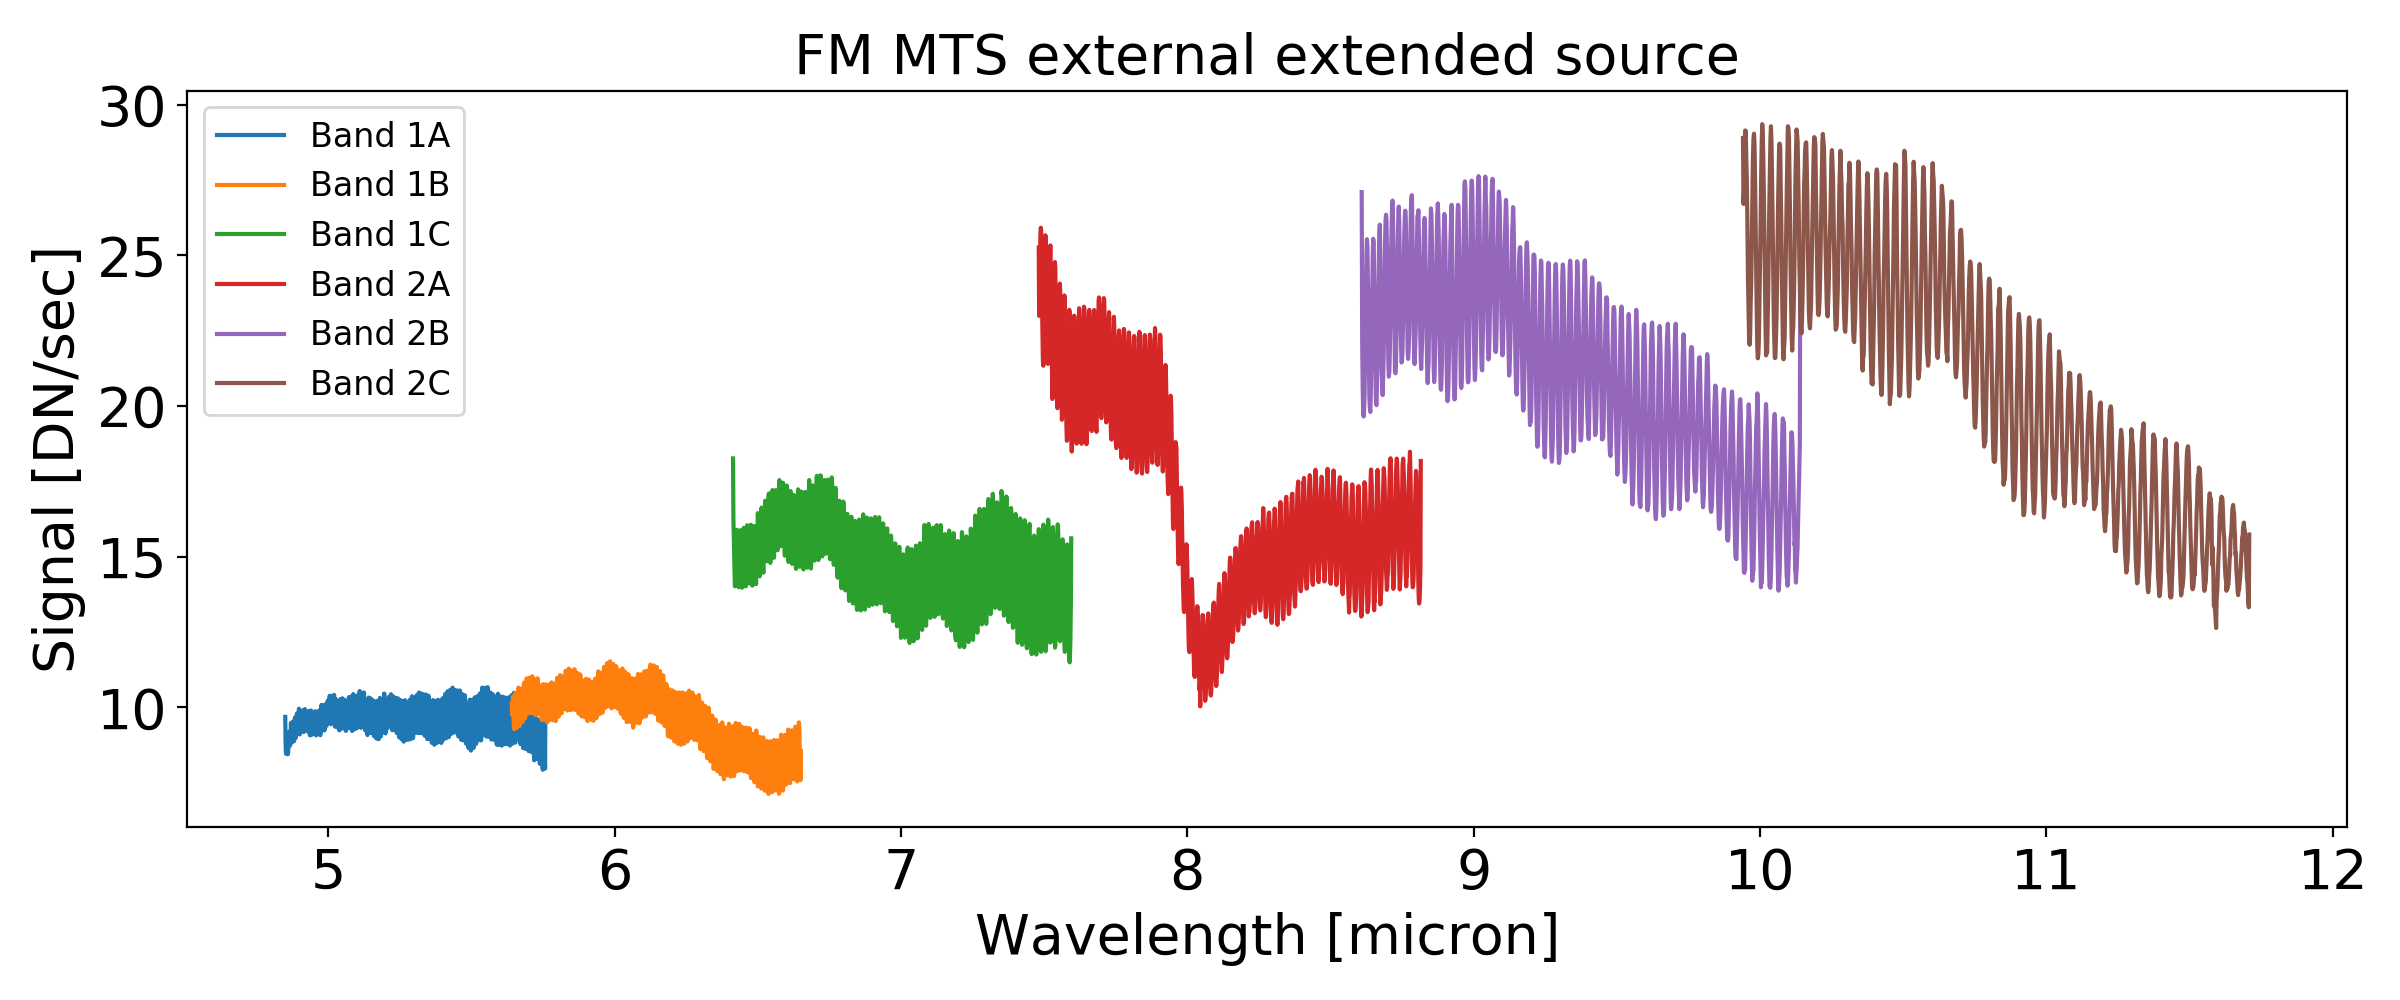

<IPython.core.display.Javascript object>


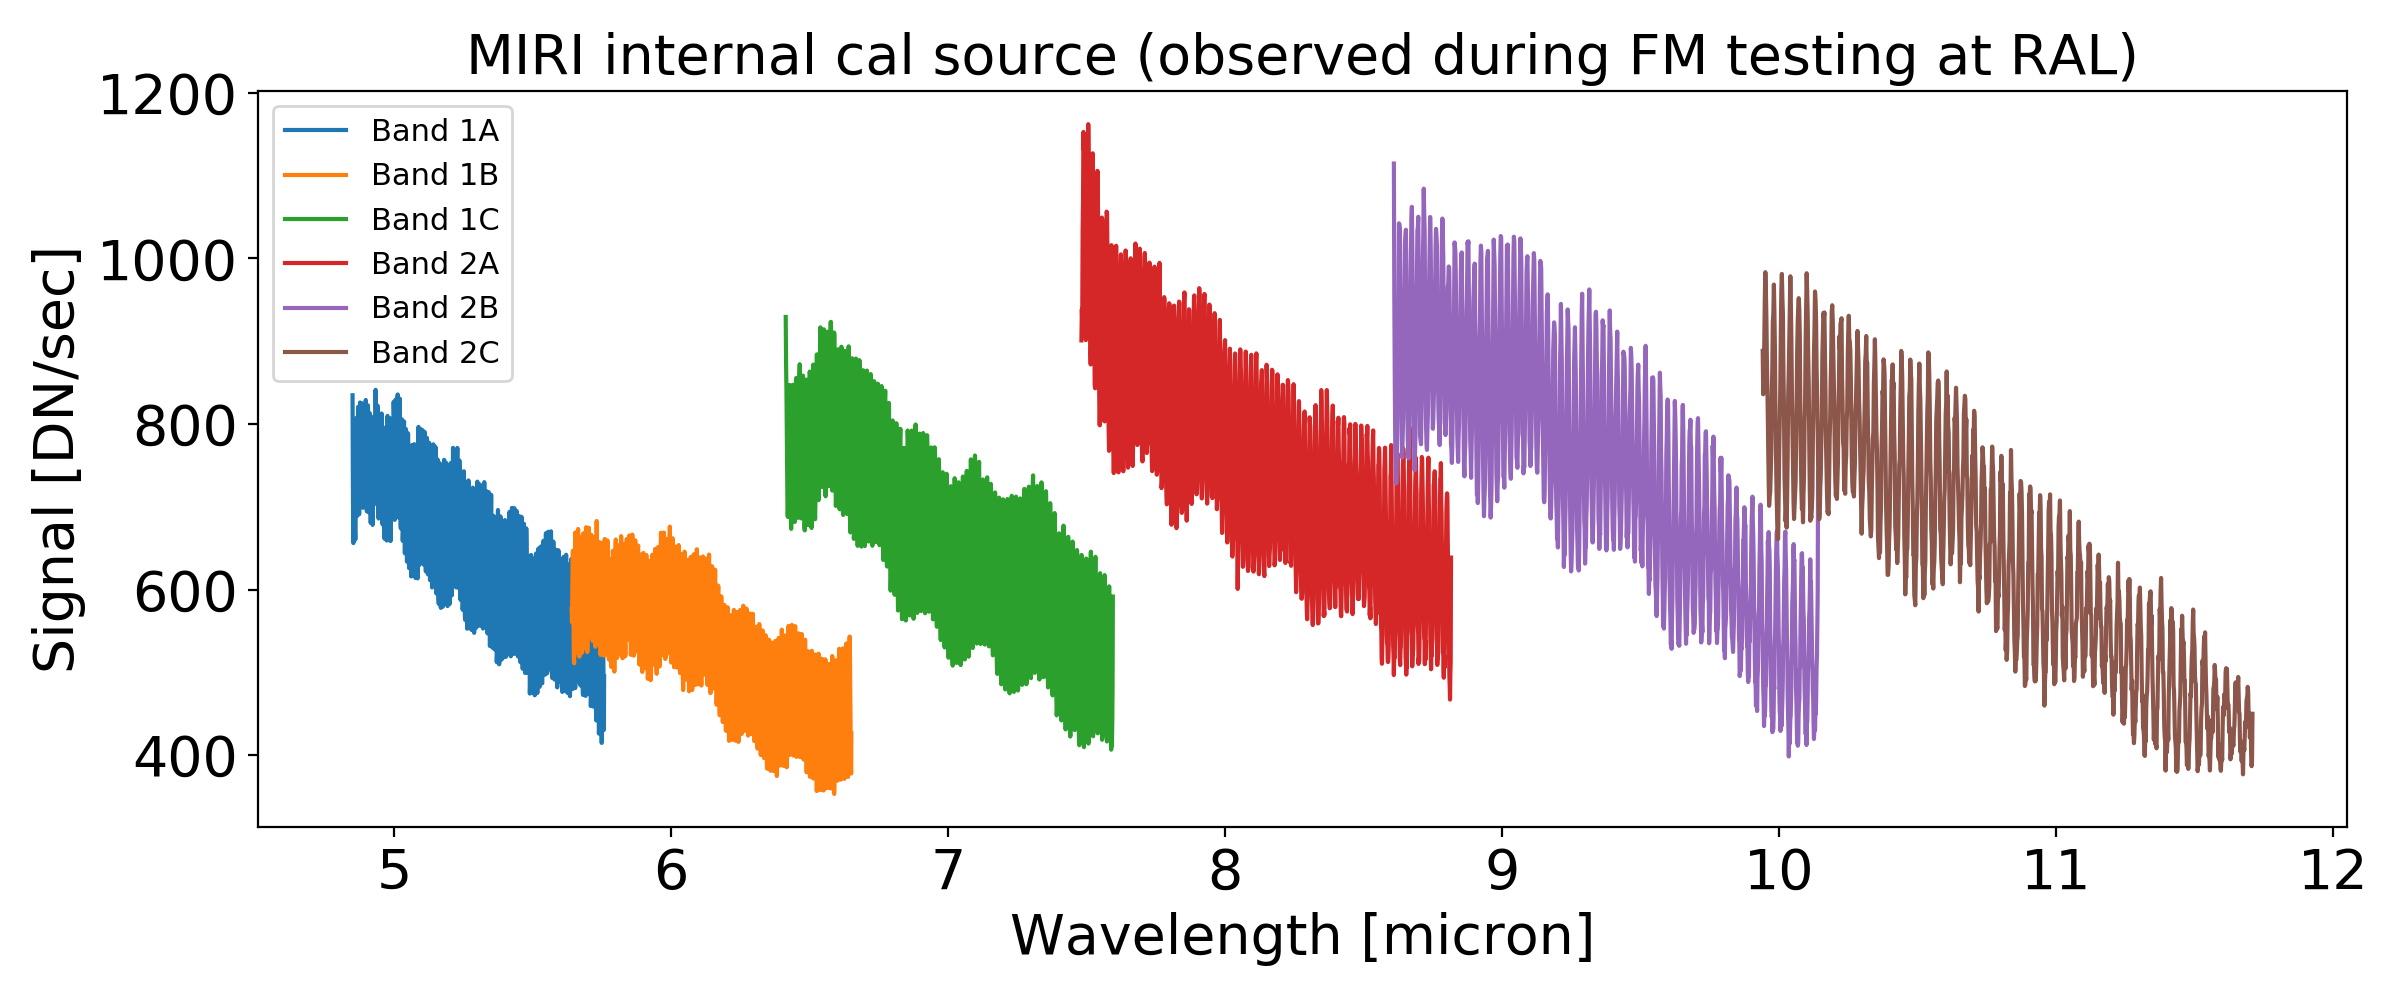

<IPython.core.display.Javascript object>


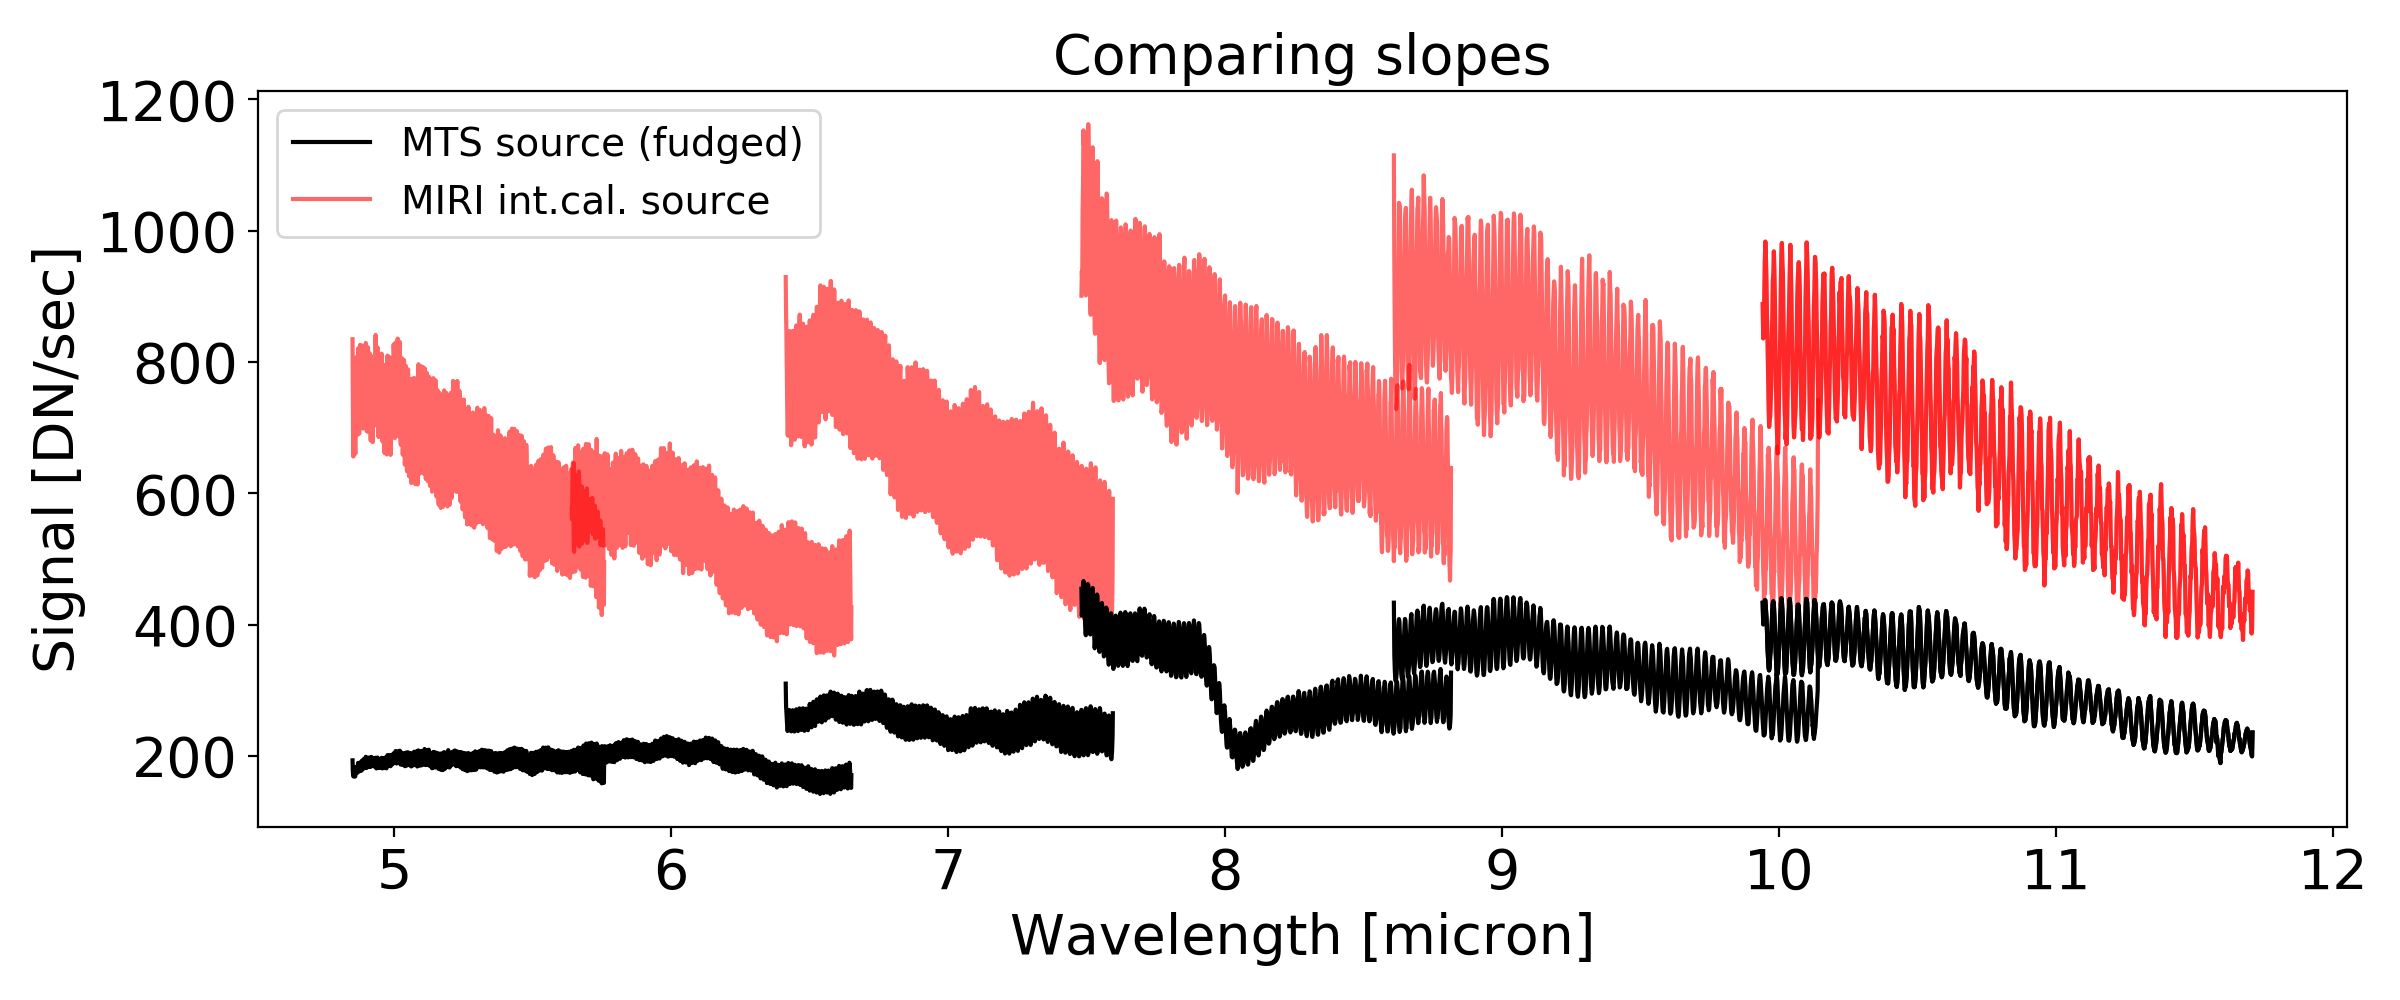

<IPython.core.display.Javascript object>


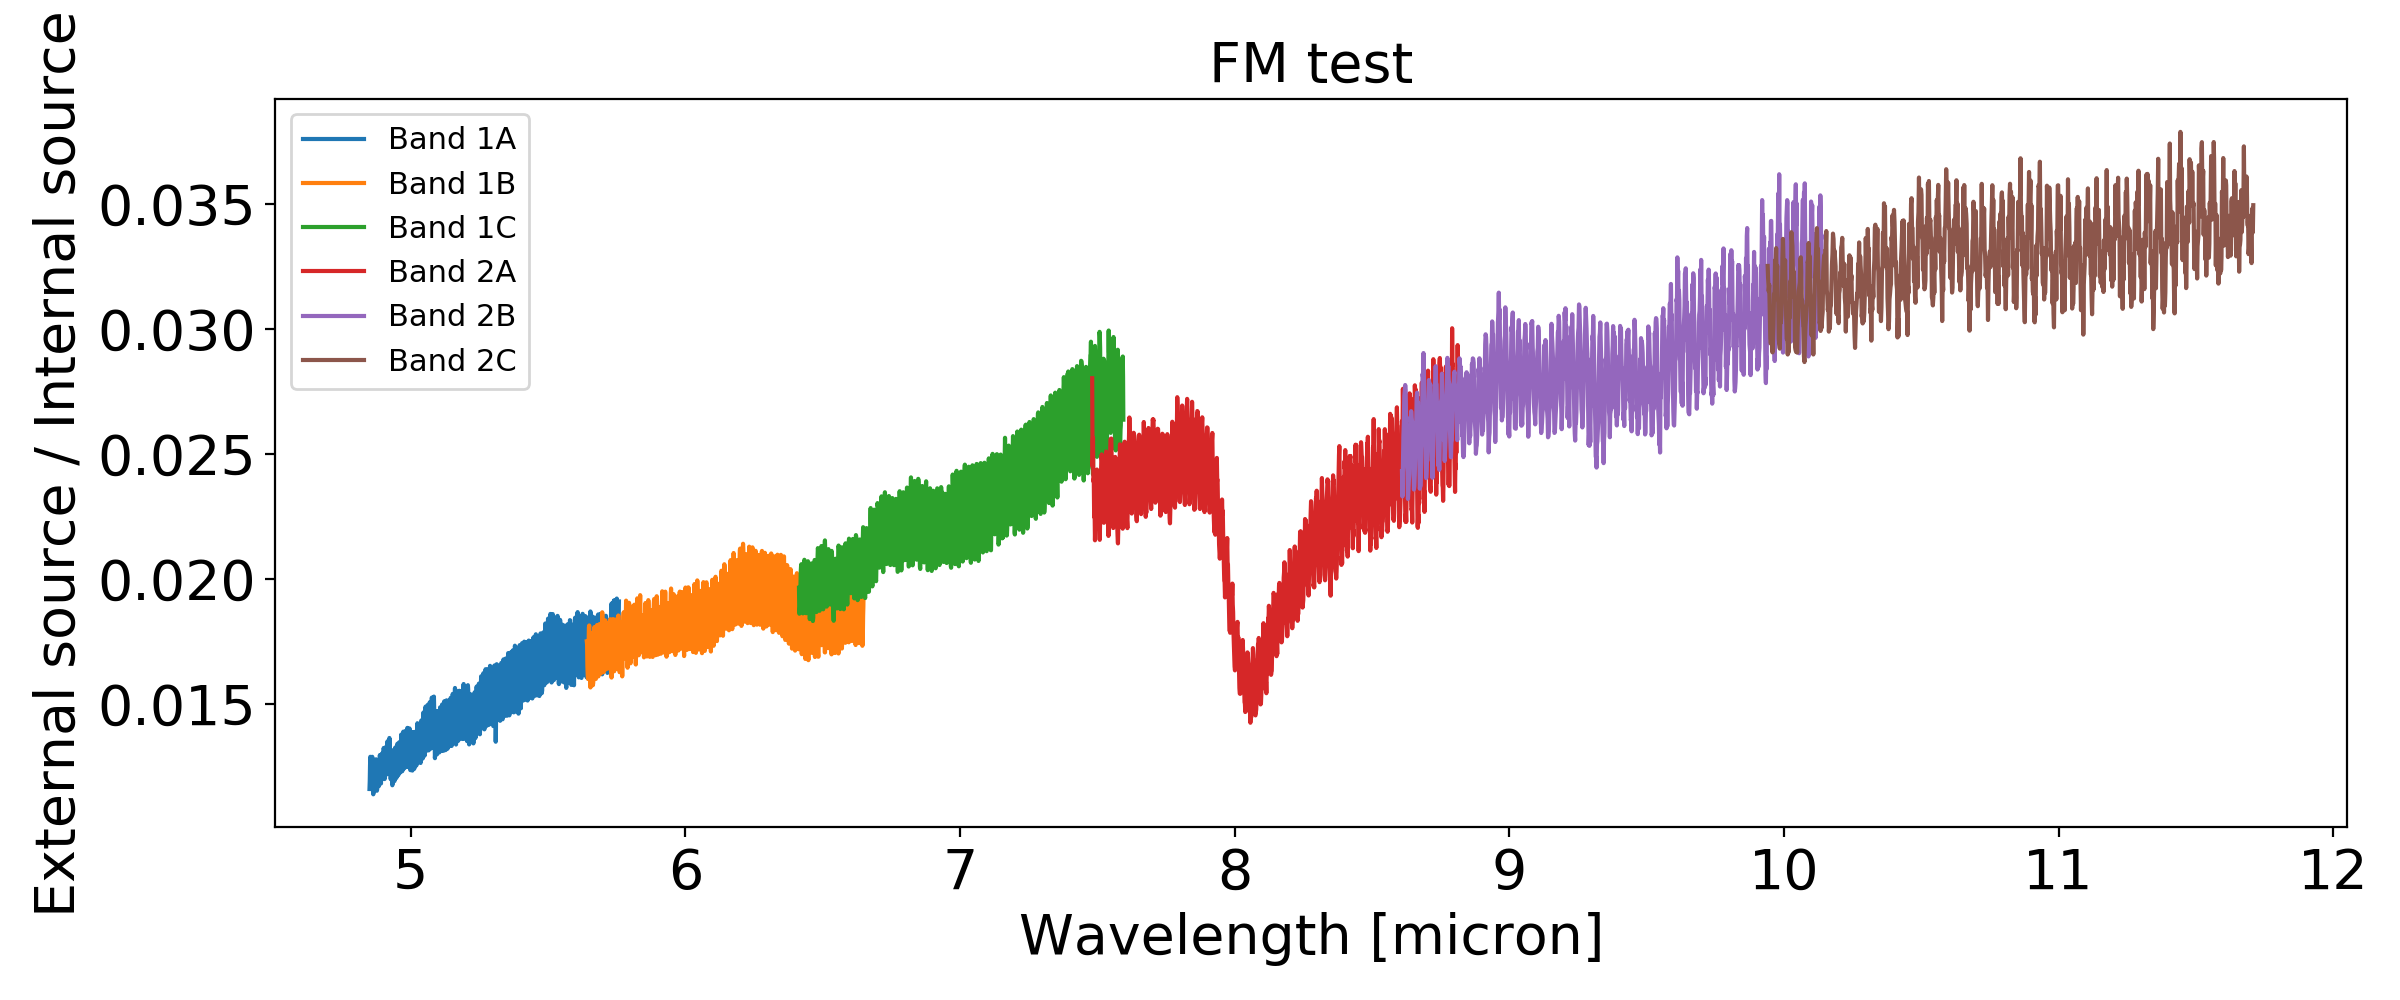

In [111]:
# plot pixel trace
plt.figure(figsize=(12,5))
plt.title('FM MTS external extended source')
for band in ['1A','1B','1C','2A','2B','2C']:
    plt.plot(lambdaMap[band][ypos,xpos[band]],ext_source_bkgsubtr[band][ypos,xpos[band]],label='Band {}'.format(band))
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper left',fontsize=12)
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('MIRI internal cal source (observed during FM testing at RAL)')
for band in ['1A','1B','1C','2A','2B','2C']:
    plt.plot(lambdaMap[band][ypos,xpos[band]],FM_intcal_source_sci[band][ypos,xpos[band]],label='Band {}'.format(band))
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper left',fontsize=11)
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('Comparing slopes')
for band in ['1A','1B','1C','2A','2B','2C']:
    if band in ['1A','1B']: fudge_factor = 20
    elif band in ['1C']: fudge_factor = 17
    elif band in ['2A']: fudge_factor = 18
    elif band in ['2B']: fudge_factor = 16
    elif band in ['2C']: fudge_factor = 15
    plt.plot(lambdaMap[band][ypos,xpos[band]],ext_source_bkgsubtr[band][ypos,xpos[band]]*fudge_factor,'k')
    plt.plot(lambdaMap[band][ypos,xpos[band]],FM_intcal_source_sci[band][ypos,xpos[band]],'r',alpha=0.6)
plt.plot(lambdaMap[band][ypos,xpos[band]],ext_source_bkgsubtr[band][ypos,xpos[band]]*fudge_factor,'k',label='MTS source (fudged)')
plt.plot(lambdaMap[band][ypos,xpos[band]],FM_intcal_source_sci[band][ypos,xpos[band]],'r',alpha=0.6,label='MIRI int.cal. source')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper left')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('FM test')
for band in ['1A','1B','1C','2A','2B','2C']:
    plt.plot(lambdaMap[band][ypos,xpos[band]],(ext_source_bkgsubtr[band]/FM_intcal_source_sci[band])[ypos,xpos[band]],label='Band {}'.format(band))
plt.xlabel('Wavelength [micron]')
plt.ylabel('External source / Internal source')
plt.legend(loc='upper left',fontsize=11)
plt.tight_layout()

<IPython.core.display.Javascript object>


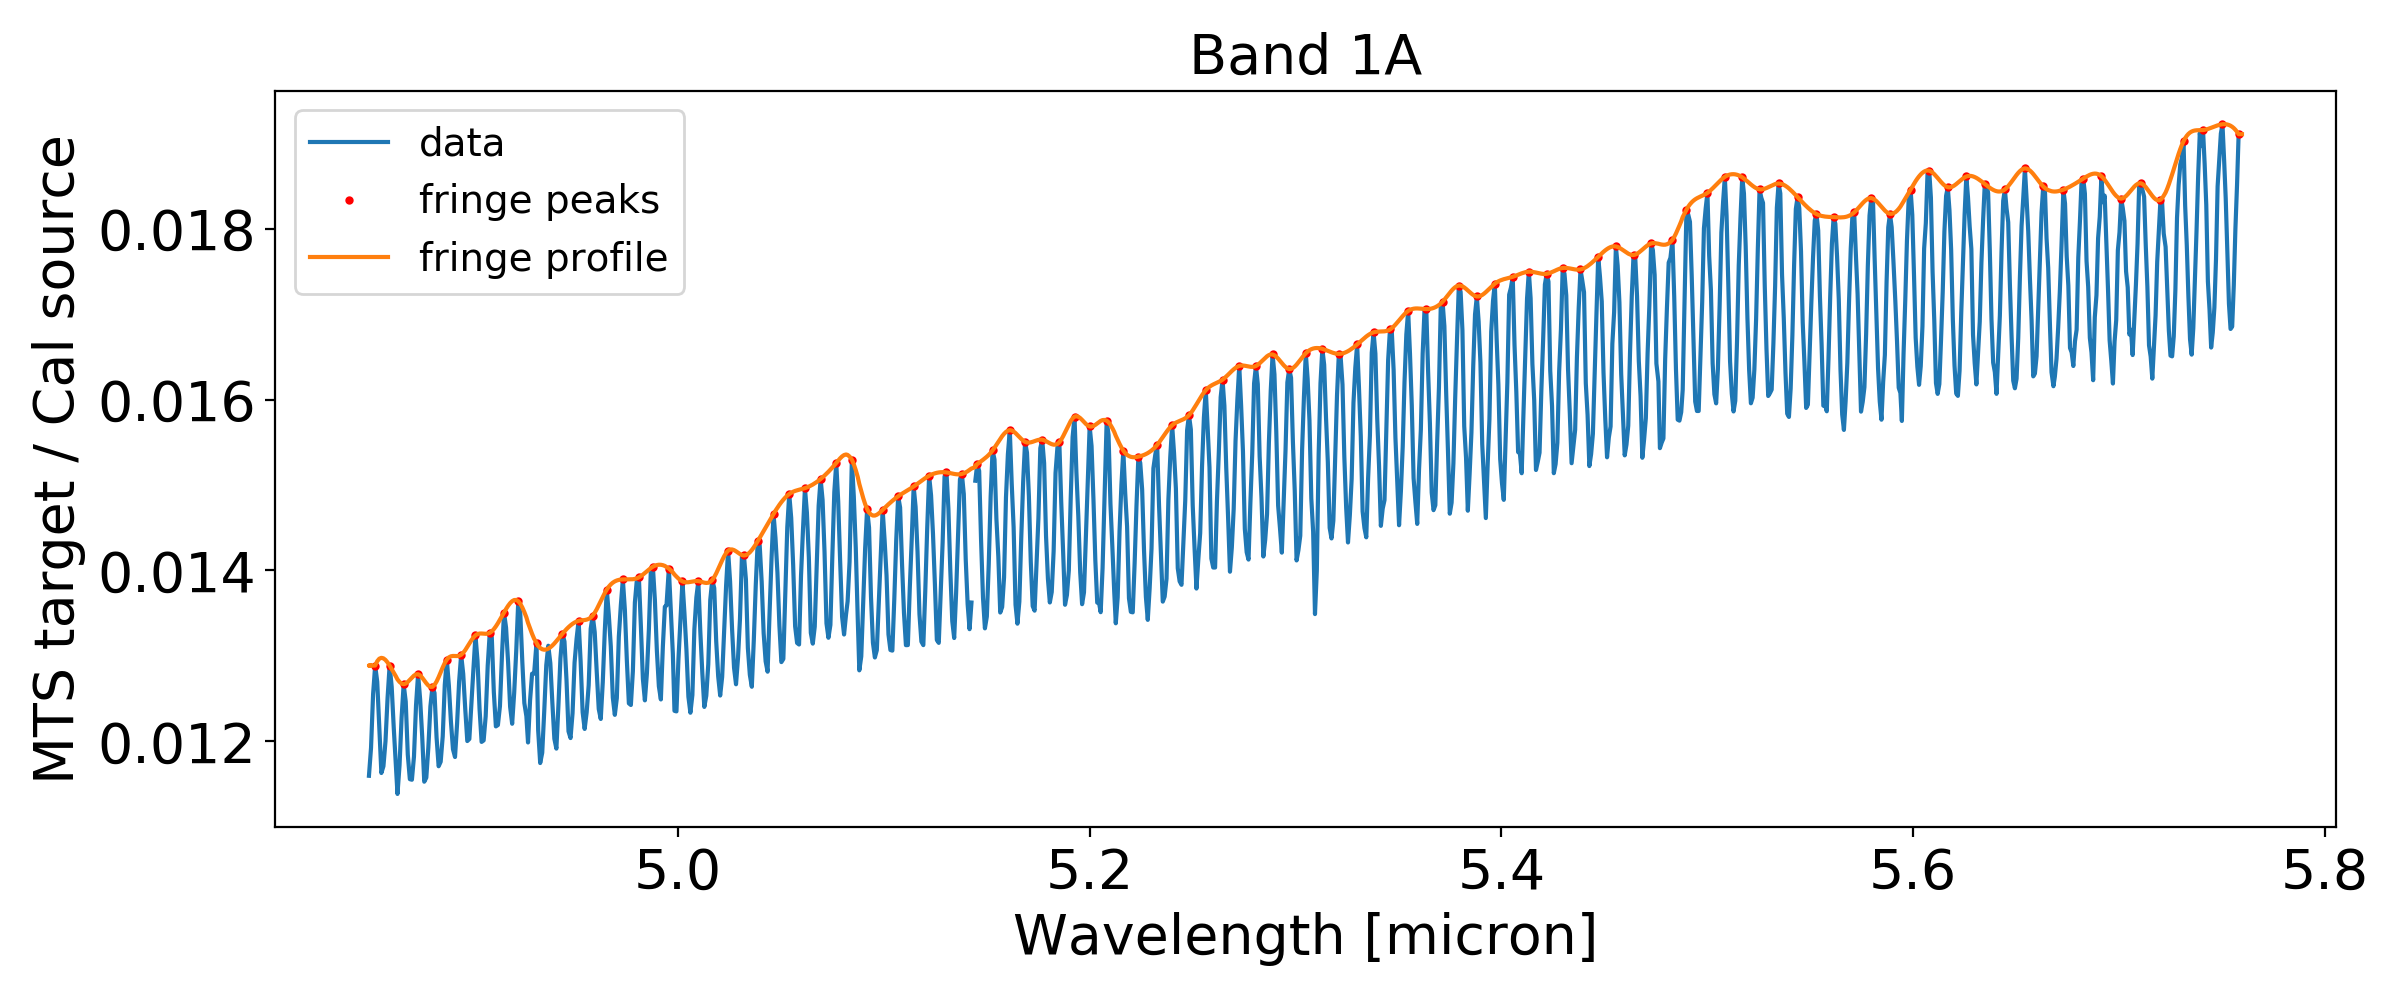

<IPython.core.display.Javascript object>


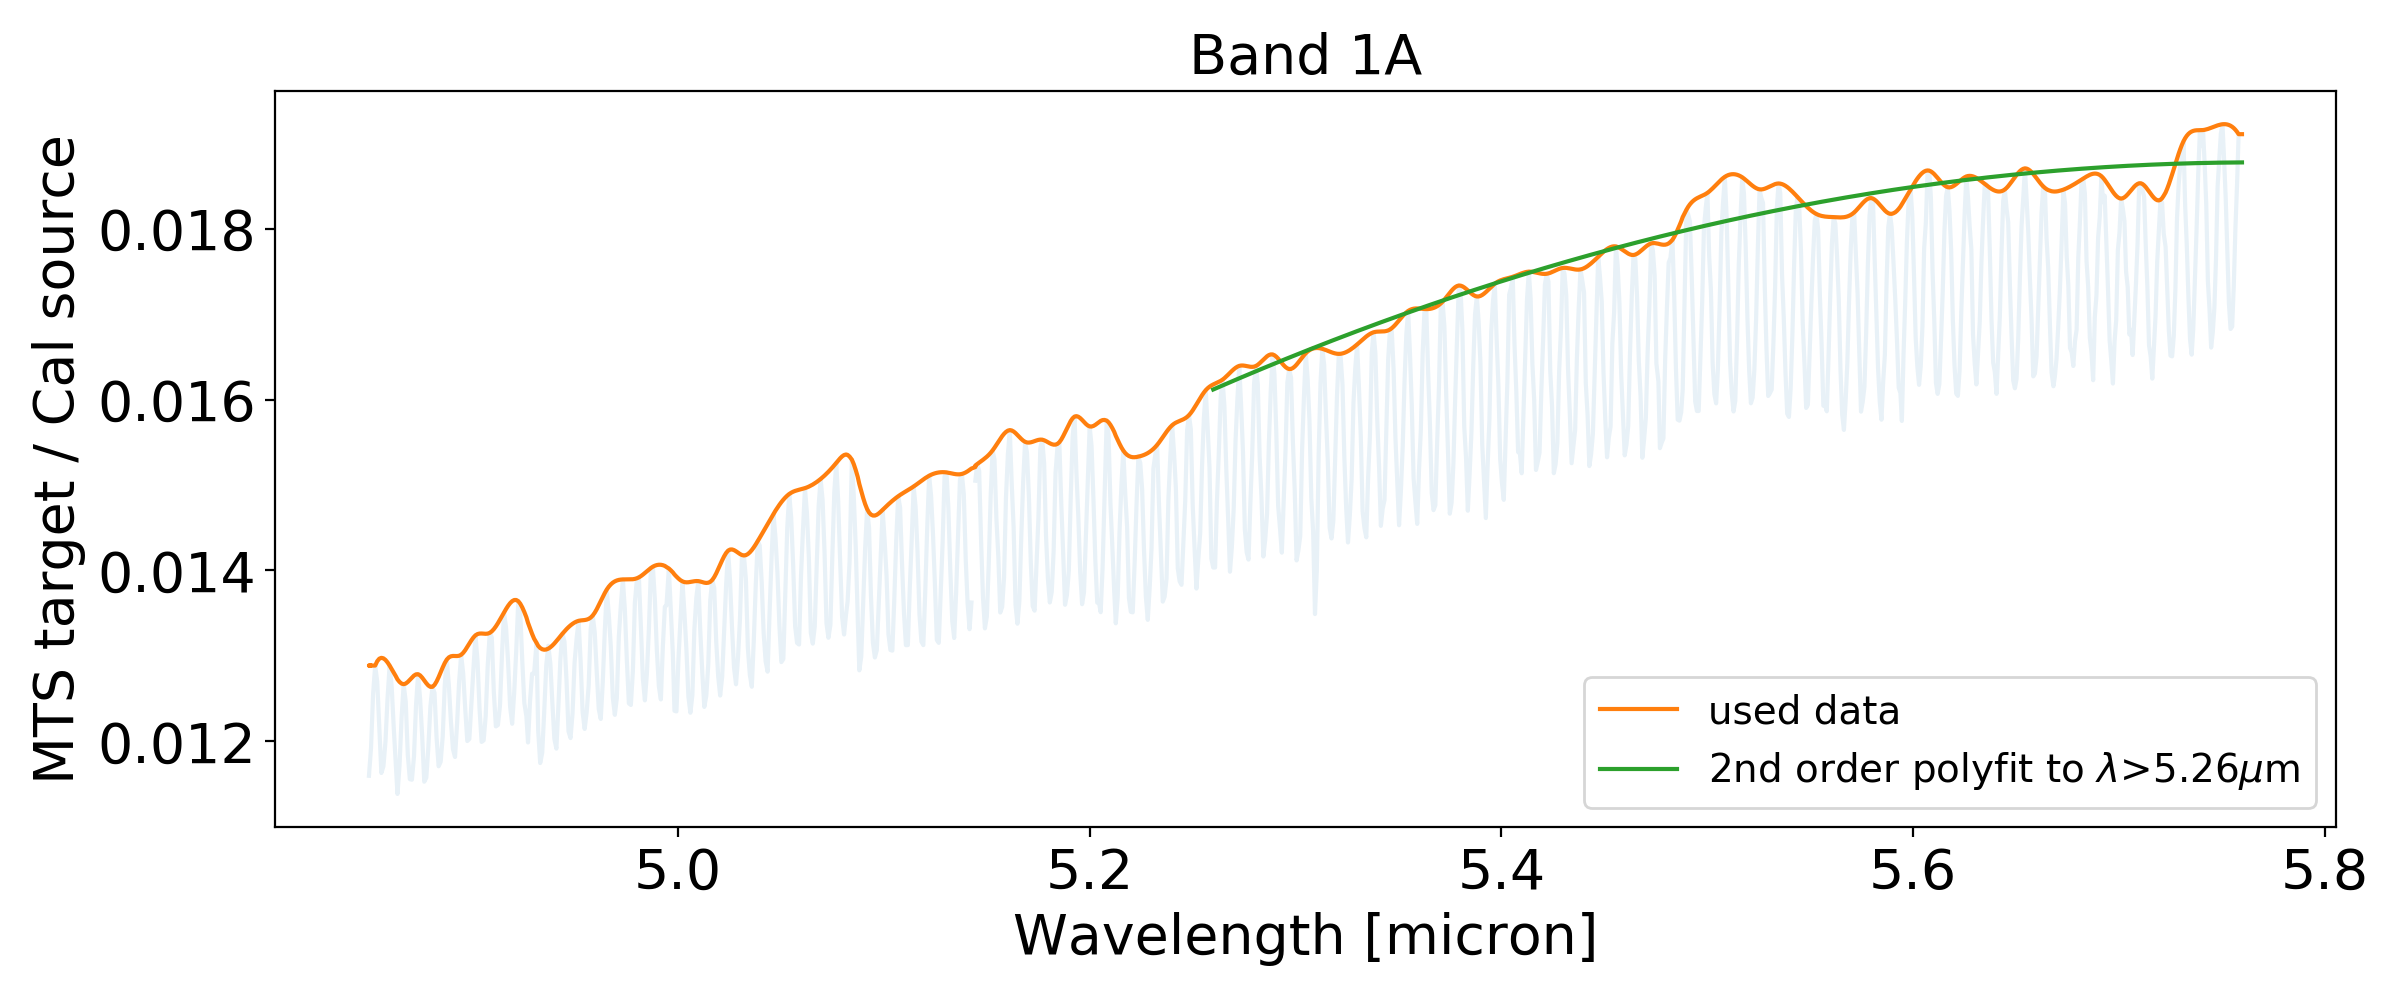

In [112]:
# Examine the OSIM sky flat data in band 1B
band = '1A'
lambdas = lambdaMap[band][ypos,xpos[band]]
data = (ext_source_bkgsubtr[band]/FM_intcal_source_sci[band])[ypos,xpos[band]]
data_noNaN,peaks,data_profile = funcs.norm_fringe(data,thres=0,min_dist=6,k=3,ext=3)

# plot starter analysis
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,label='data')
plt.plot(lambdas[peaks],data_noNaN[peaks],'ro',markersize=2,label='fringe peaks')
plt.plot(lambdas,data_profile,label='fringe profile')
plt.xlabel('Wavelength [micron]')
plt.ylabel('MTS target / Cal source')
plt.legend(loc='upper left')
plt.tight_layout()

# data_noNaN_ext,peaks_ext,data_profile_ext = funcs.norm_fringe(ext_source_bkgsubtr[band][ypos,xpos[band]],thres=0,min_dist=6,k=3,ext=3)
# data_noNaN_int,peaks_int,data_profile_int = funcs.norm_fringe(FM_intcal_source_sci[band][ypos,xpos[band]],thres=0,min_dist=6,k=3,ext=3)

# data = data_profile_ext/data_profile_int
# data_noNaN,peaks,data_profile = funcs.norm_fringe(data,thres=0,min_dist=6,k=3,ext=3)

# plt.figure(figsize=(12,5))
# plt.title('Band {}'.format(band))
# plt.plot(lambdas,data,label='data')
# plt.plot(lambdas[peaks],data_noNaN[peaks],'ro',markersize=2,label='fringe peaks')
# plt.plot(lambdas,data_profile,label='fringe profile')
# plt.xlabel('Wavelength [micron]')
# plt.ylabel('MTS target / Cal source')
# plt.legend(loc='upper left')
# plt.tight_layout()

# Investigate regions of interest
sel = (lambdas>5.26) #& (lambdas<5.47)
popt1     = np.polyfit(lambdas[sel],data_profile[sel],2)
poly1     = np.poly1d(popt1)

# plot resulting fits and residuals
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,alpha=0.1)
plt.plot(lambdas,data_profile,label='used data')
plt.plot(lambdas[(lambdas>5.26)],poly1(lambdas[(lambdas>5.26)]),label=r'2nd order polyfit to $\lambda$>5.26$\mu$m')
plt.xlabel('Wavelength [micron]')
plt.ylabel('MTS target / Cal source')
plt.legend(loc='lower right')
plt.tight_layout()


<IPython.core.display.Javascript object>


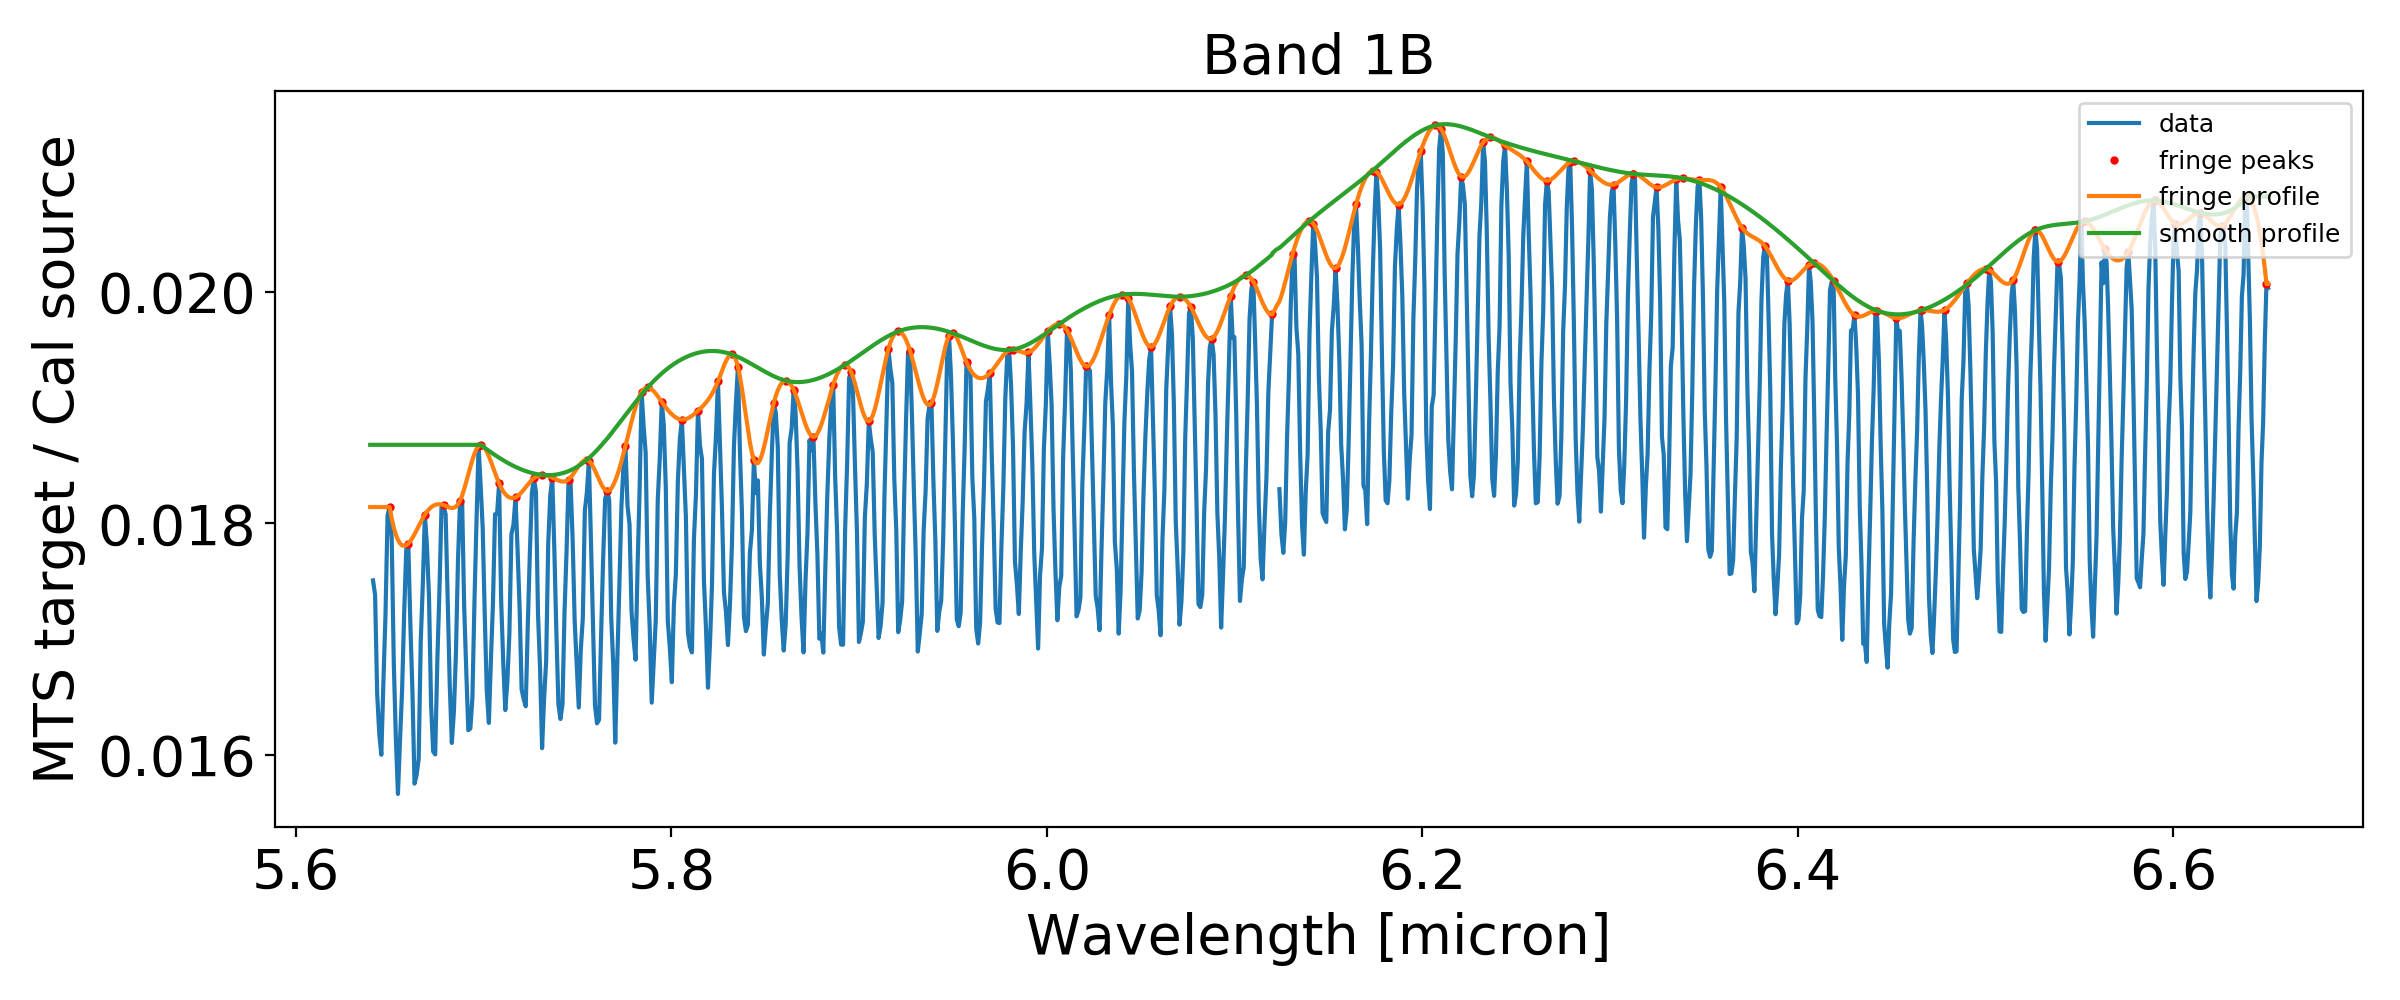

<IPython.core.display.Javascript object>


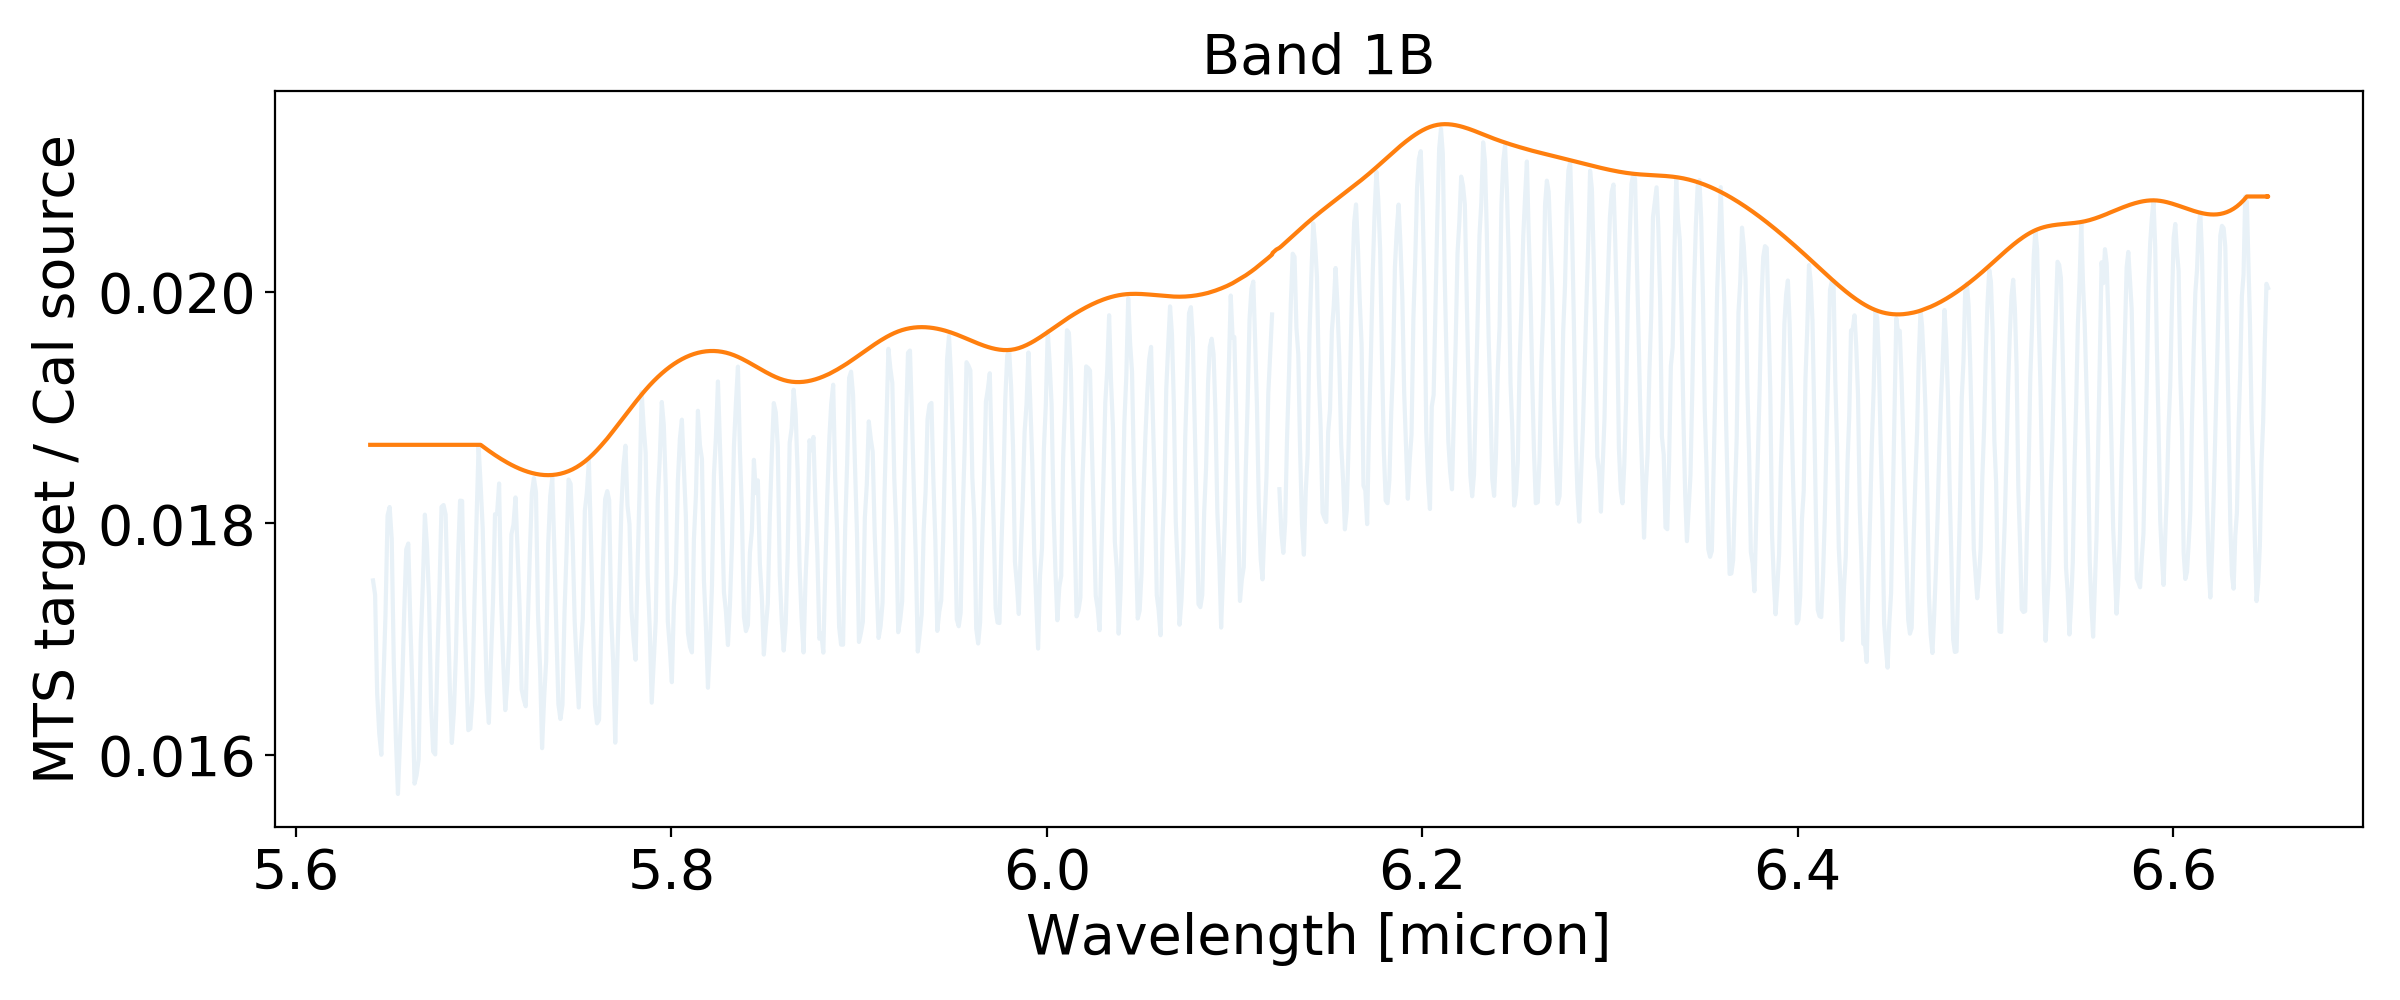

In [113]:
# Examine the OSIM sky flat data in band 1B (wavelength range 5.62-6.73 micron)
band = '1B'
lambdas = lambdaMap[band][ypos,xpos[band]]
data = (ext_source_bkgsubtr[band]/FM_intcal_source_sci[band])[ypos,xpos[band]]
data_noNaN,peaks,data_profile = funcs.norm_fringe(data,thres=0,min_dist=7,k=3,ext=3)
data_noNaN2,peaks2,data_profile2 = funcs.norm_fringe(data_profile,thres=0,min_dist=20,k=3,ext=3)

# plot starter analysis
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,label='data')
plt.plot(lambdas[peaks],data_noNaN[peaks],'ro',markersize=2,label='fringe peaks')
plt.plot(lambdas[peaks2],data_noNaN2[peaks2],'ro',markersize=2)
plt.plot(lambdas,data_profile,label='fringe profile')
plt.plot(lambdas,data_profile2,label='smooth profile')
plt.xlabel('Wavelength [micron]')
plt.ylabel('MTS target / Cal source')
plt.legend(loc='upper right',fontsize=9)
plt.tight_layout()

# plot resulting fits and residuals
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,alpha=0.1)
plt.plot(lambdas,data_profile2)
plt.xlabel('Wavelength [micron]')
plt.ylabel('MTS target / Cal source')
plt.legend(loc='upper right')
plt.tight_layout()


<IPython.core.display.Javascript object>


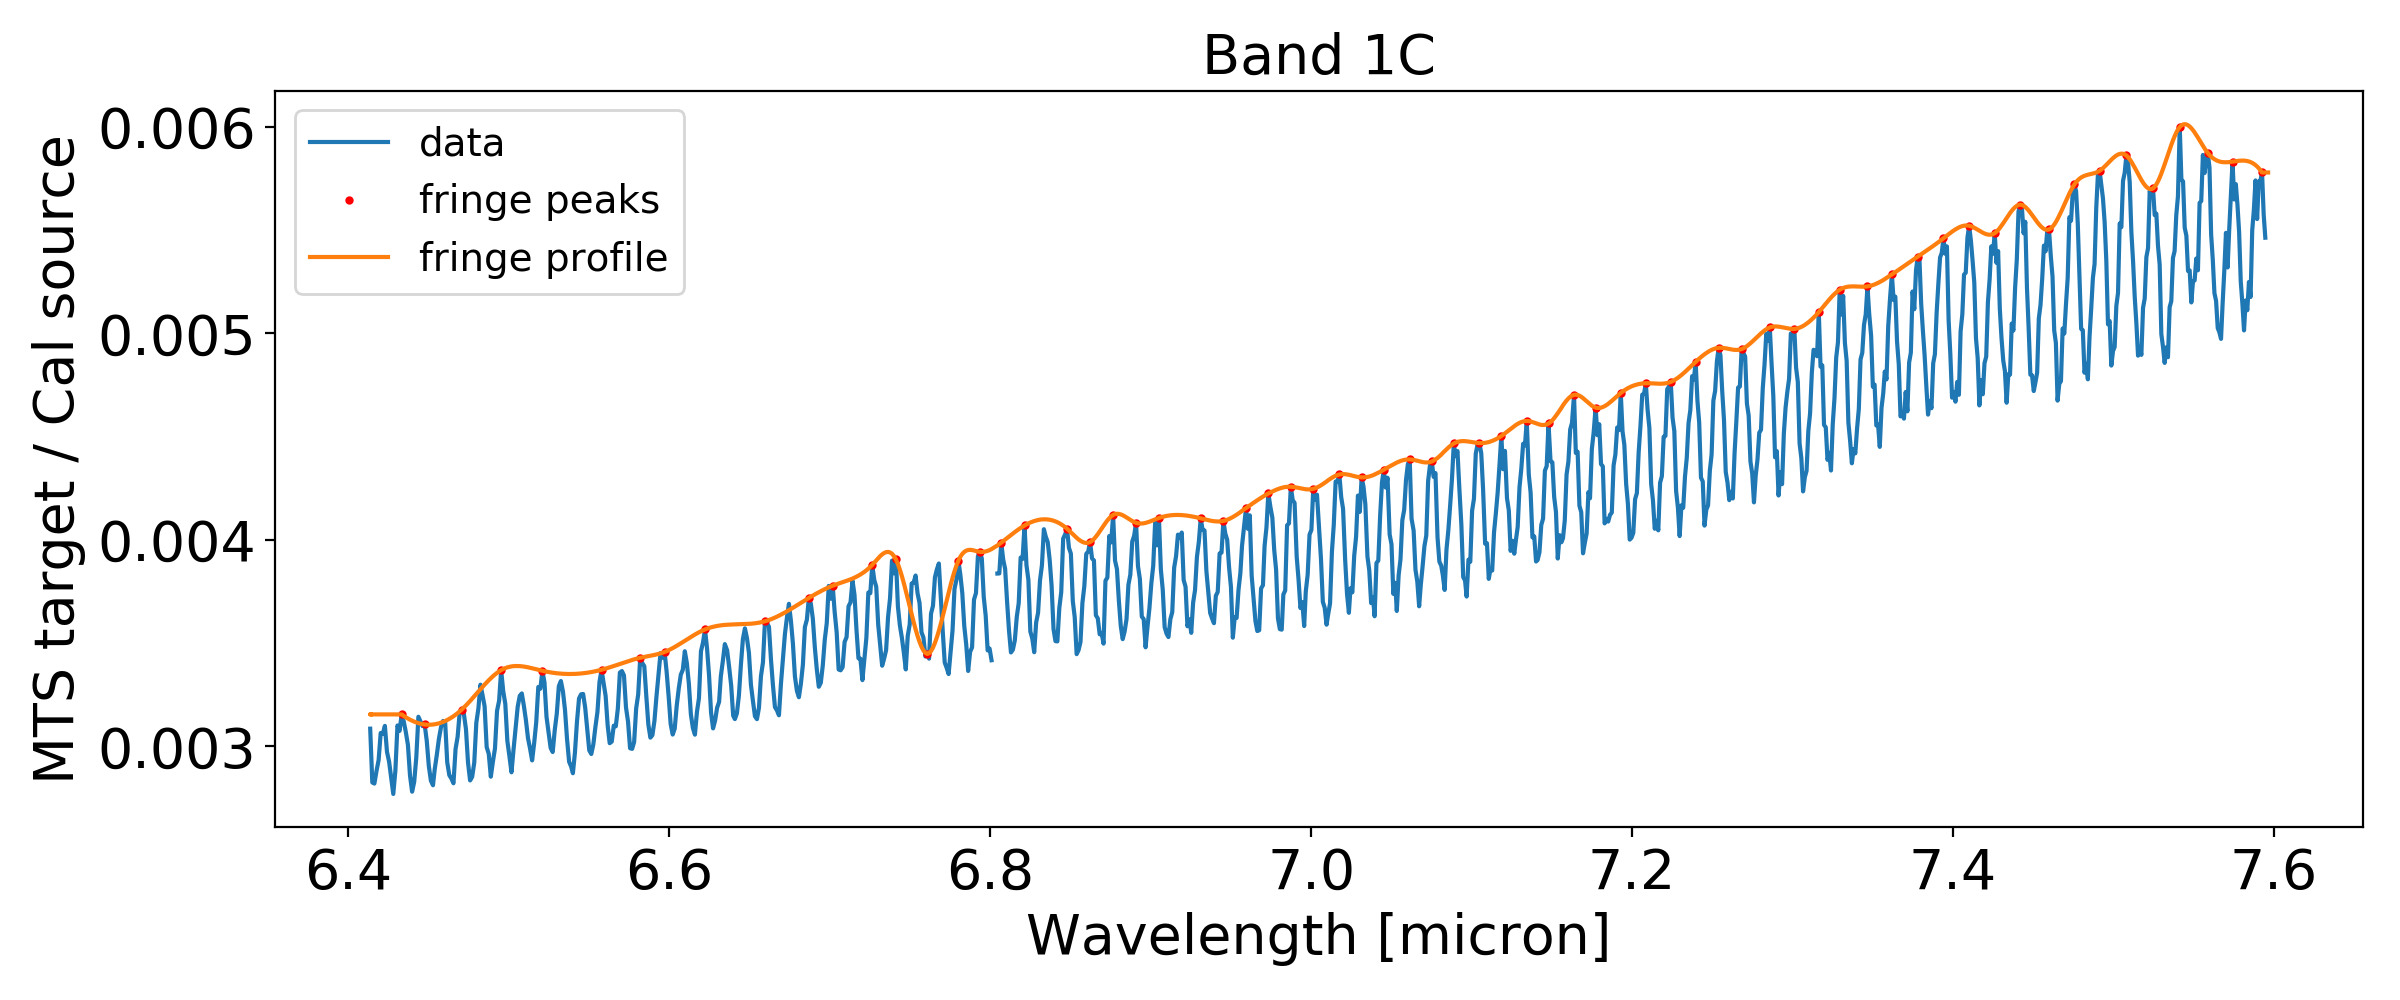

<IPython.core.display.Javascript object>


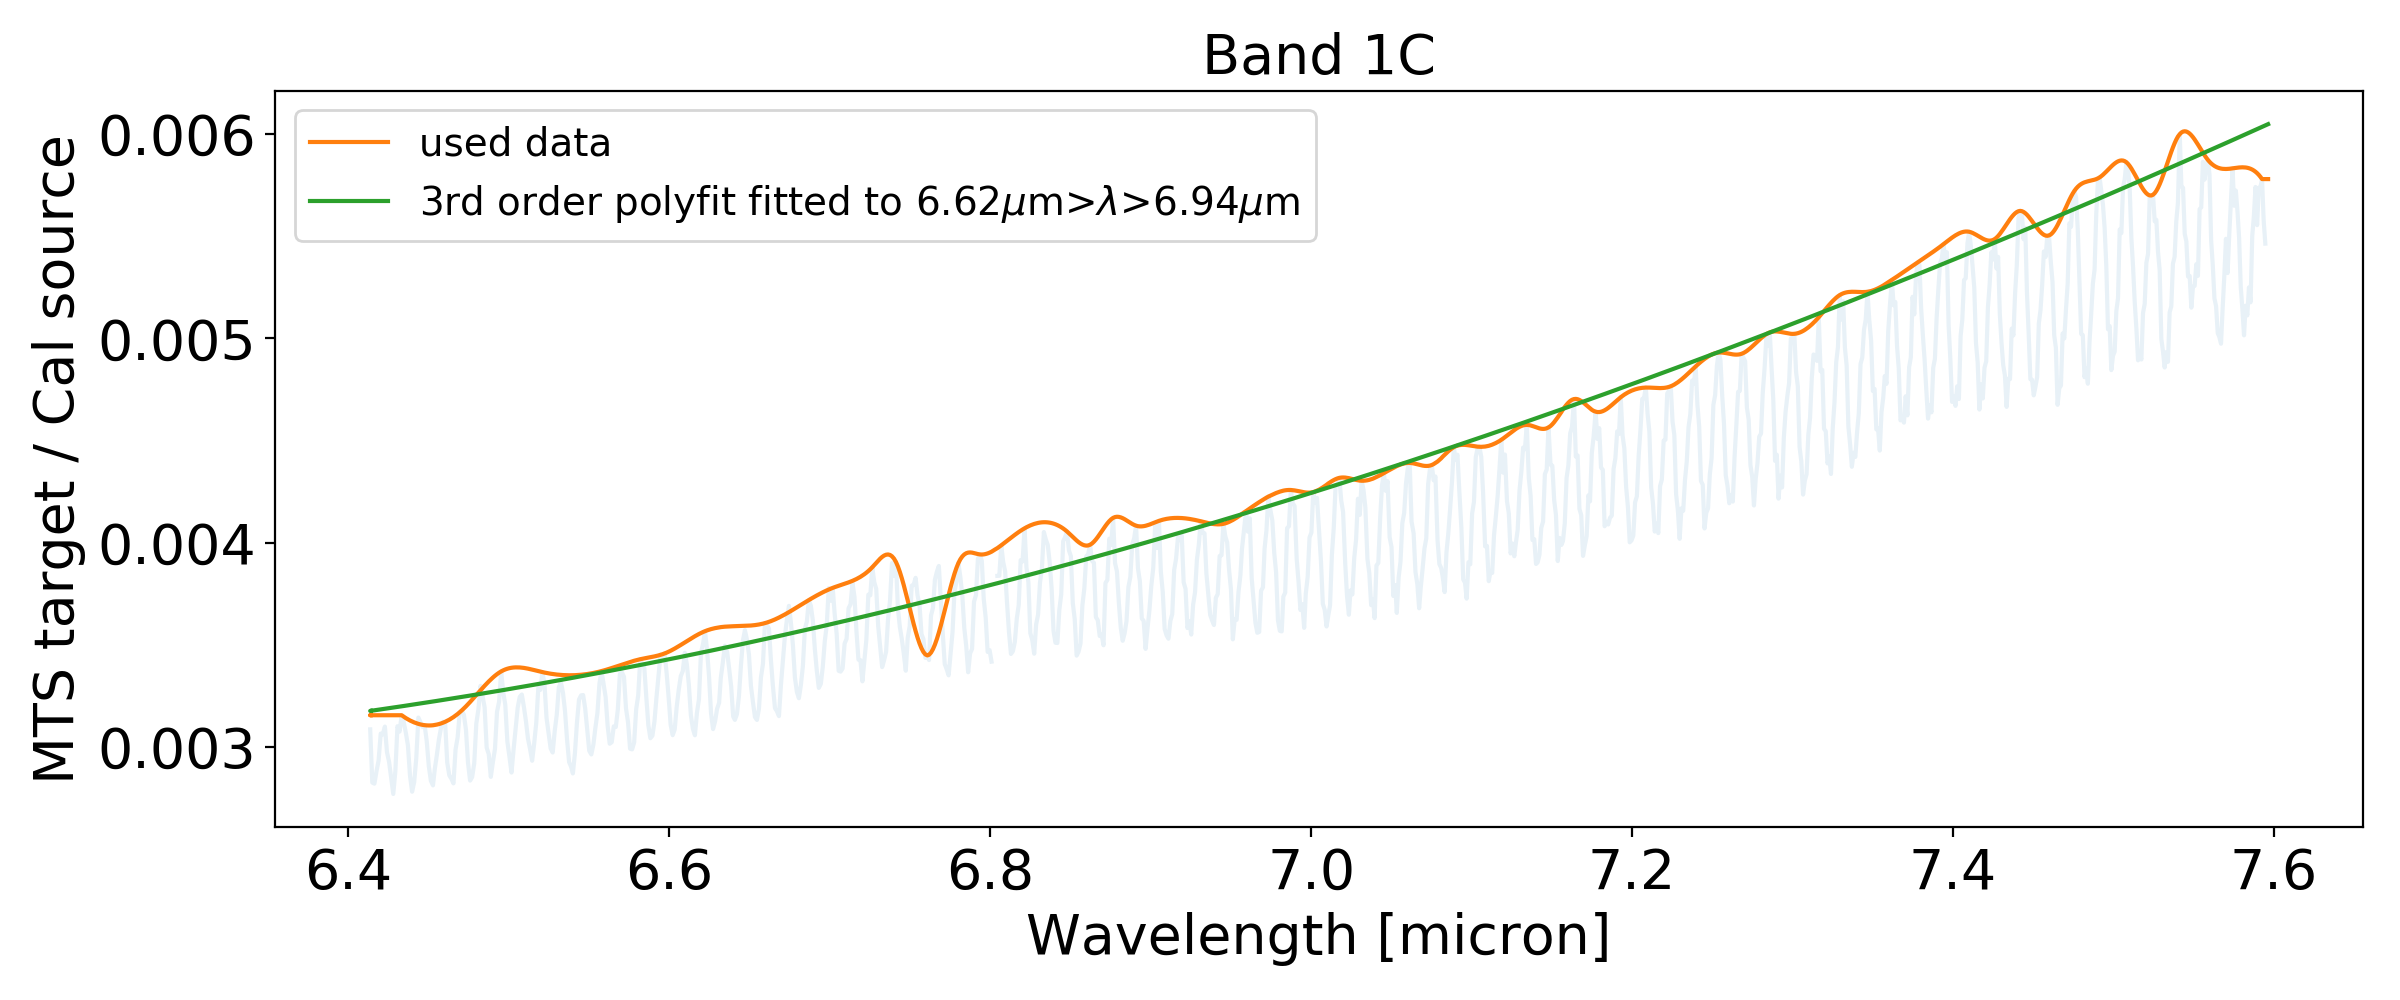

In [106]:
# Examine the OSIM sky flat data in band 1C (wavelength range 5.62-6.73 micron)
band = '1C'
lambdas = lambdaMap[band][ypos,xpos[band]]
data = (ext_source_bkgsubtr[band]/FM_intcal_source_sci[band])[ypos,xpos[band]]
data_noNaN,peaks,data_profile = funcs.norm_fringe(data,thres=0,min_dist=10,k=3,ext=3)

# plot starter analysis
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,label='data')
plt.plot(lambdas[peaks],data_noNaN[peaks],'ro',markersize=2,label='fringe peaks')
plt.plot(lambdas,data_profile,label='fringe profile')
plt.xlabel('Wavelength [micron]')
plt.ylabel('MTS target / Cal source')
plt.legend(loc='upper left')
plt.tight_layout()

# Investigate regions of interest
sel = (lambdas >6.62)&(lambdas <6.935)
popt1     = np.polyfit(lambdas[~sel],data_profile[~sel],3)
poly1     = np.poly1d(popt1)

# plot resulting fits and residuals
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,alpha=0.1)
plt.plot(lambdas,data_profile,label='used data')
plt.plot(lambdas,poly1(lambdas),label=r'3rd order polyfit fitted to 6.62$\mu$m>$\lambda$>6.94$\mu$m')
plt.xlabel('Wavelength [micron]')
plt.ylabel('MTS target / Cal source')
plt.legend(loc='upper left')
plt.tight_layout()

<IPython.core.display.Javascript object>


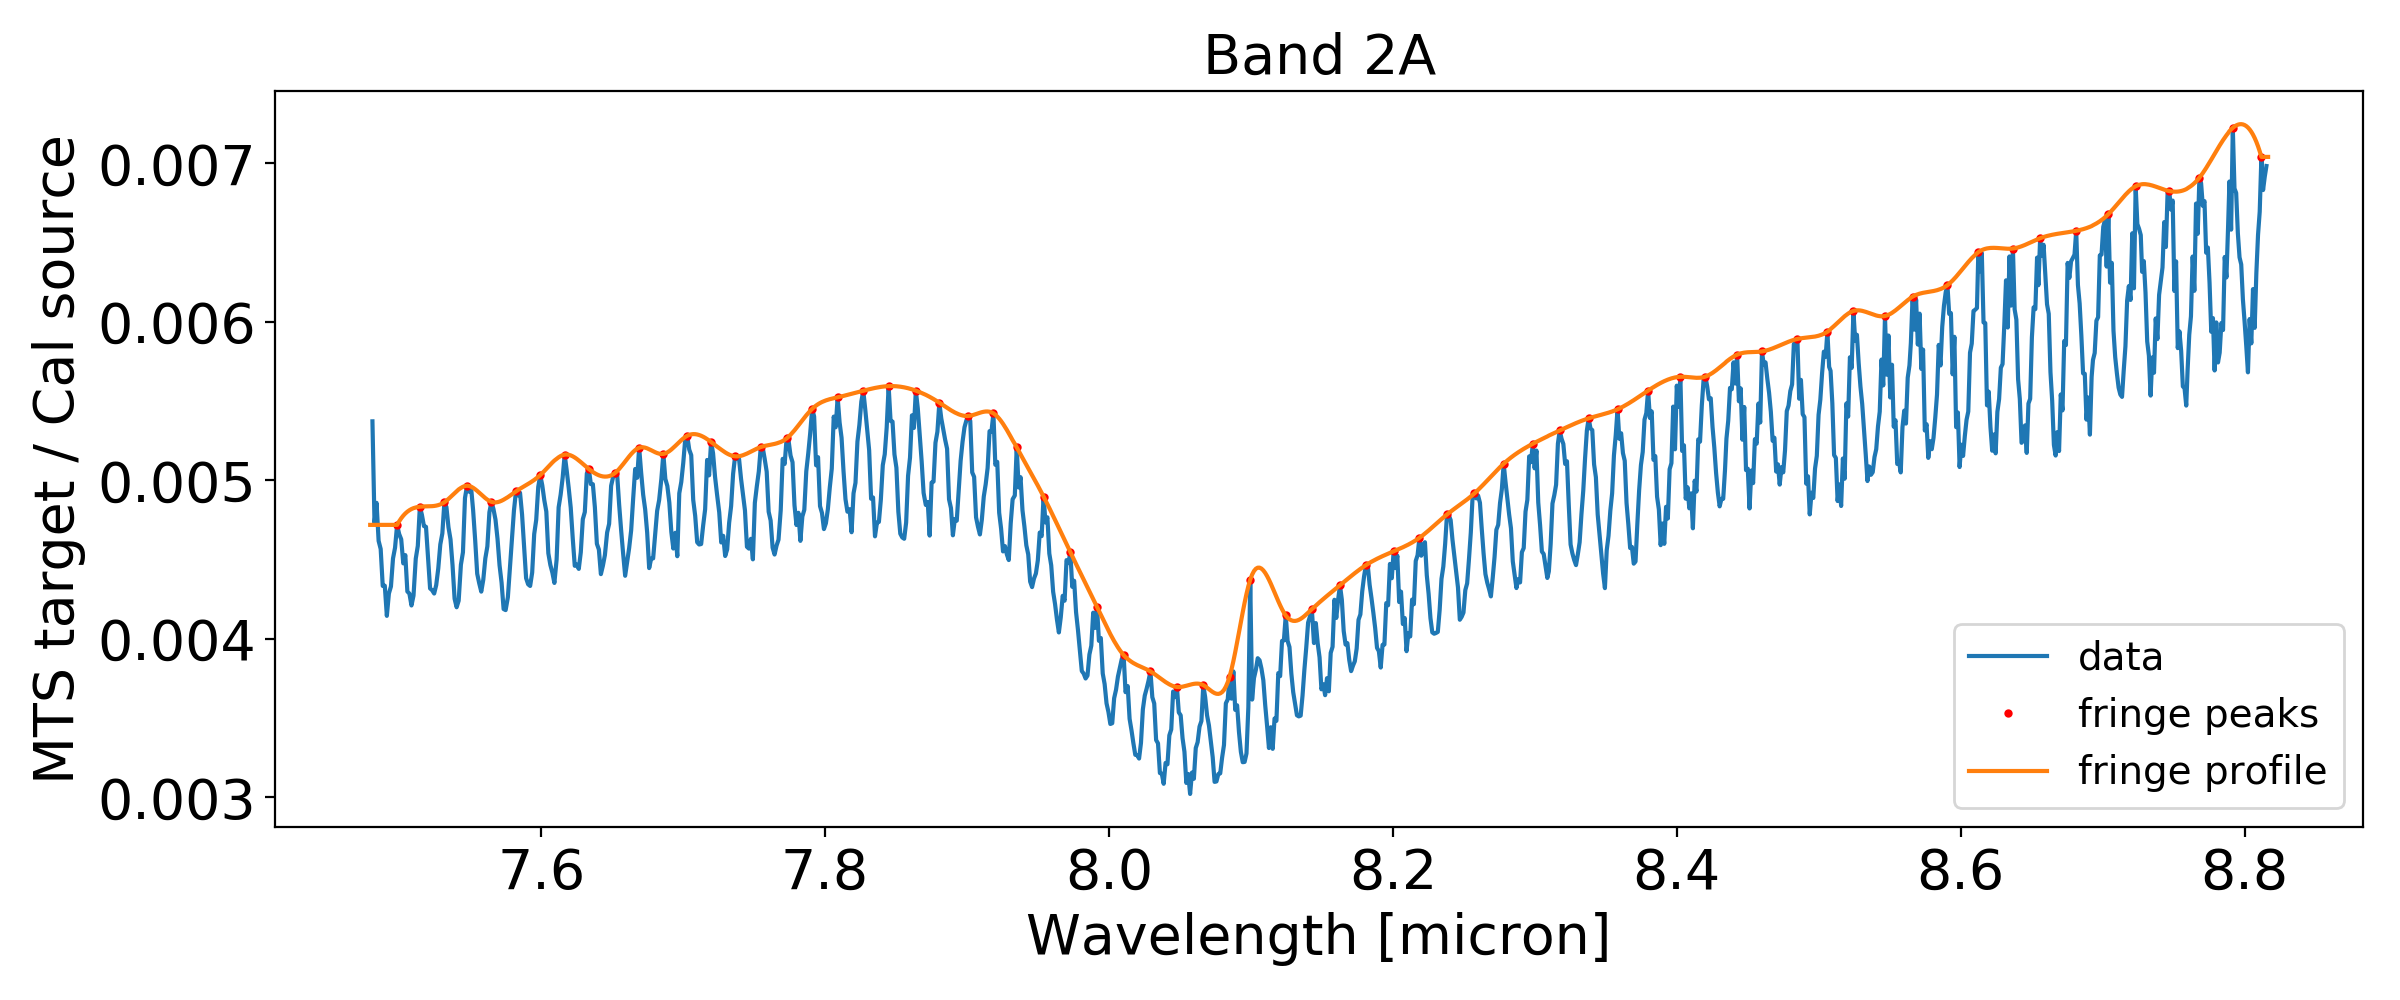

<IPython.core.display.Javascript object>


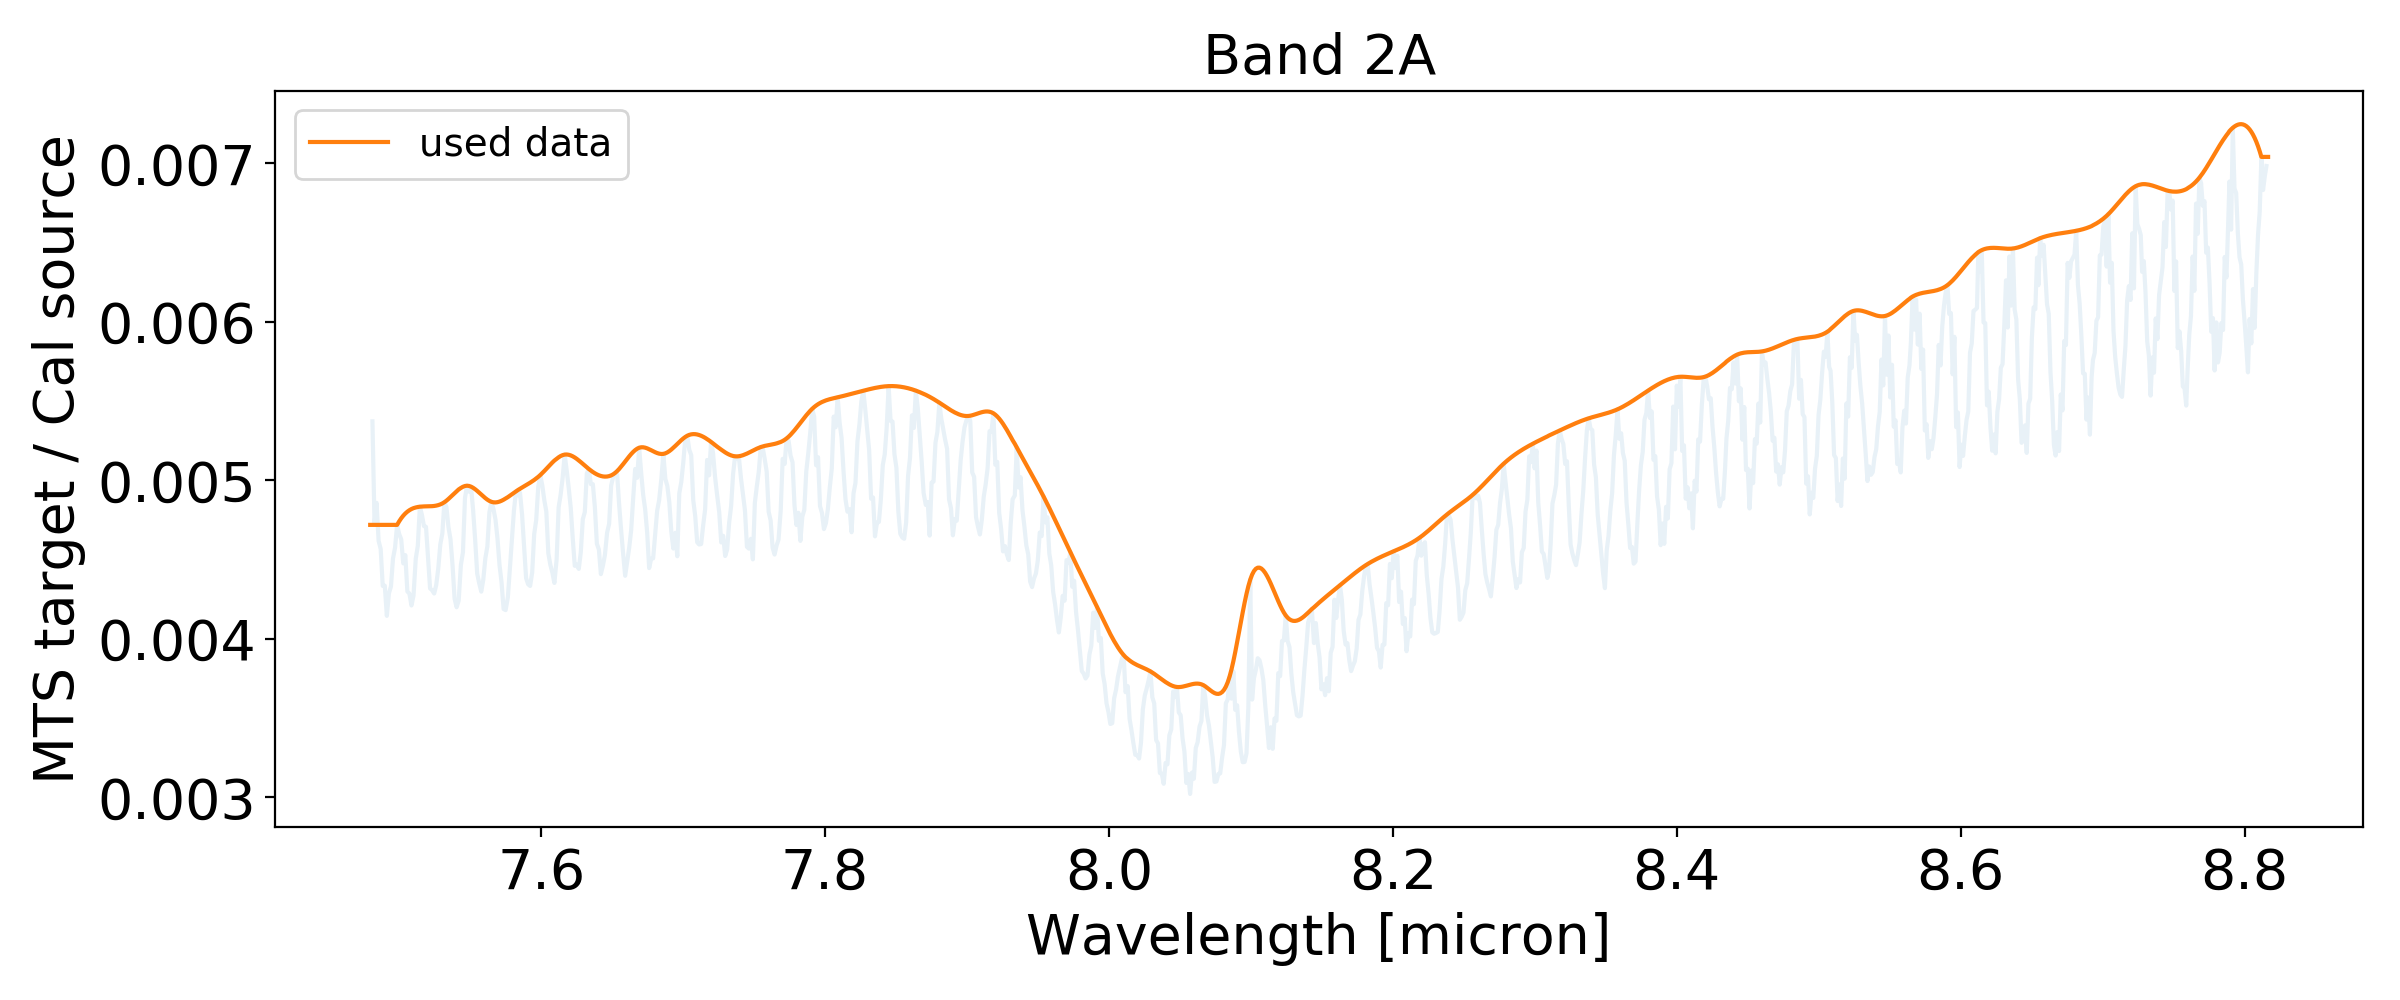

In [107]:
# Examine the OSIM sky flat data in band 1C (wavelength range 5.62-6.73 micron)
band = '2A'
lambdas = lambdaMap[band][ypos,xpos[band]]
data = (ext_source_bkgsubtr[band]/FM_intcal_source_sci[band])[ypos,xpos[band]]
data_noNaN,peaks,data_profile = funcs.norm_fringe(data,thres=0,min_dist=10,k=3,ext=3)

# plot starter analysis
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,label='data')
plt.plot(lambdas[peaks],data_noNaN[peaks],'ro',markersize=2,label='fringe peaks')
plt.plot(lambdas,data_profile,label='fringe profile')
plt.xlabel('Wavelength [micron]')
plt.ylabel('MTS target / Cal source')
plt.legend(loc='lower right')
plt.tight_layout()

# plot resulting fits and residuals
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,alpha=0.1)
plt.plot(lambdas,data_profile,label='used data')
plt.xlabel('Wavelength [micron]')
plt.ylabel('MTS target / Cal source')
plt.legend(loc='upper left')
plt.tight_layout()

<IPython.core.display.Javascript object>


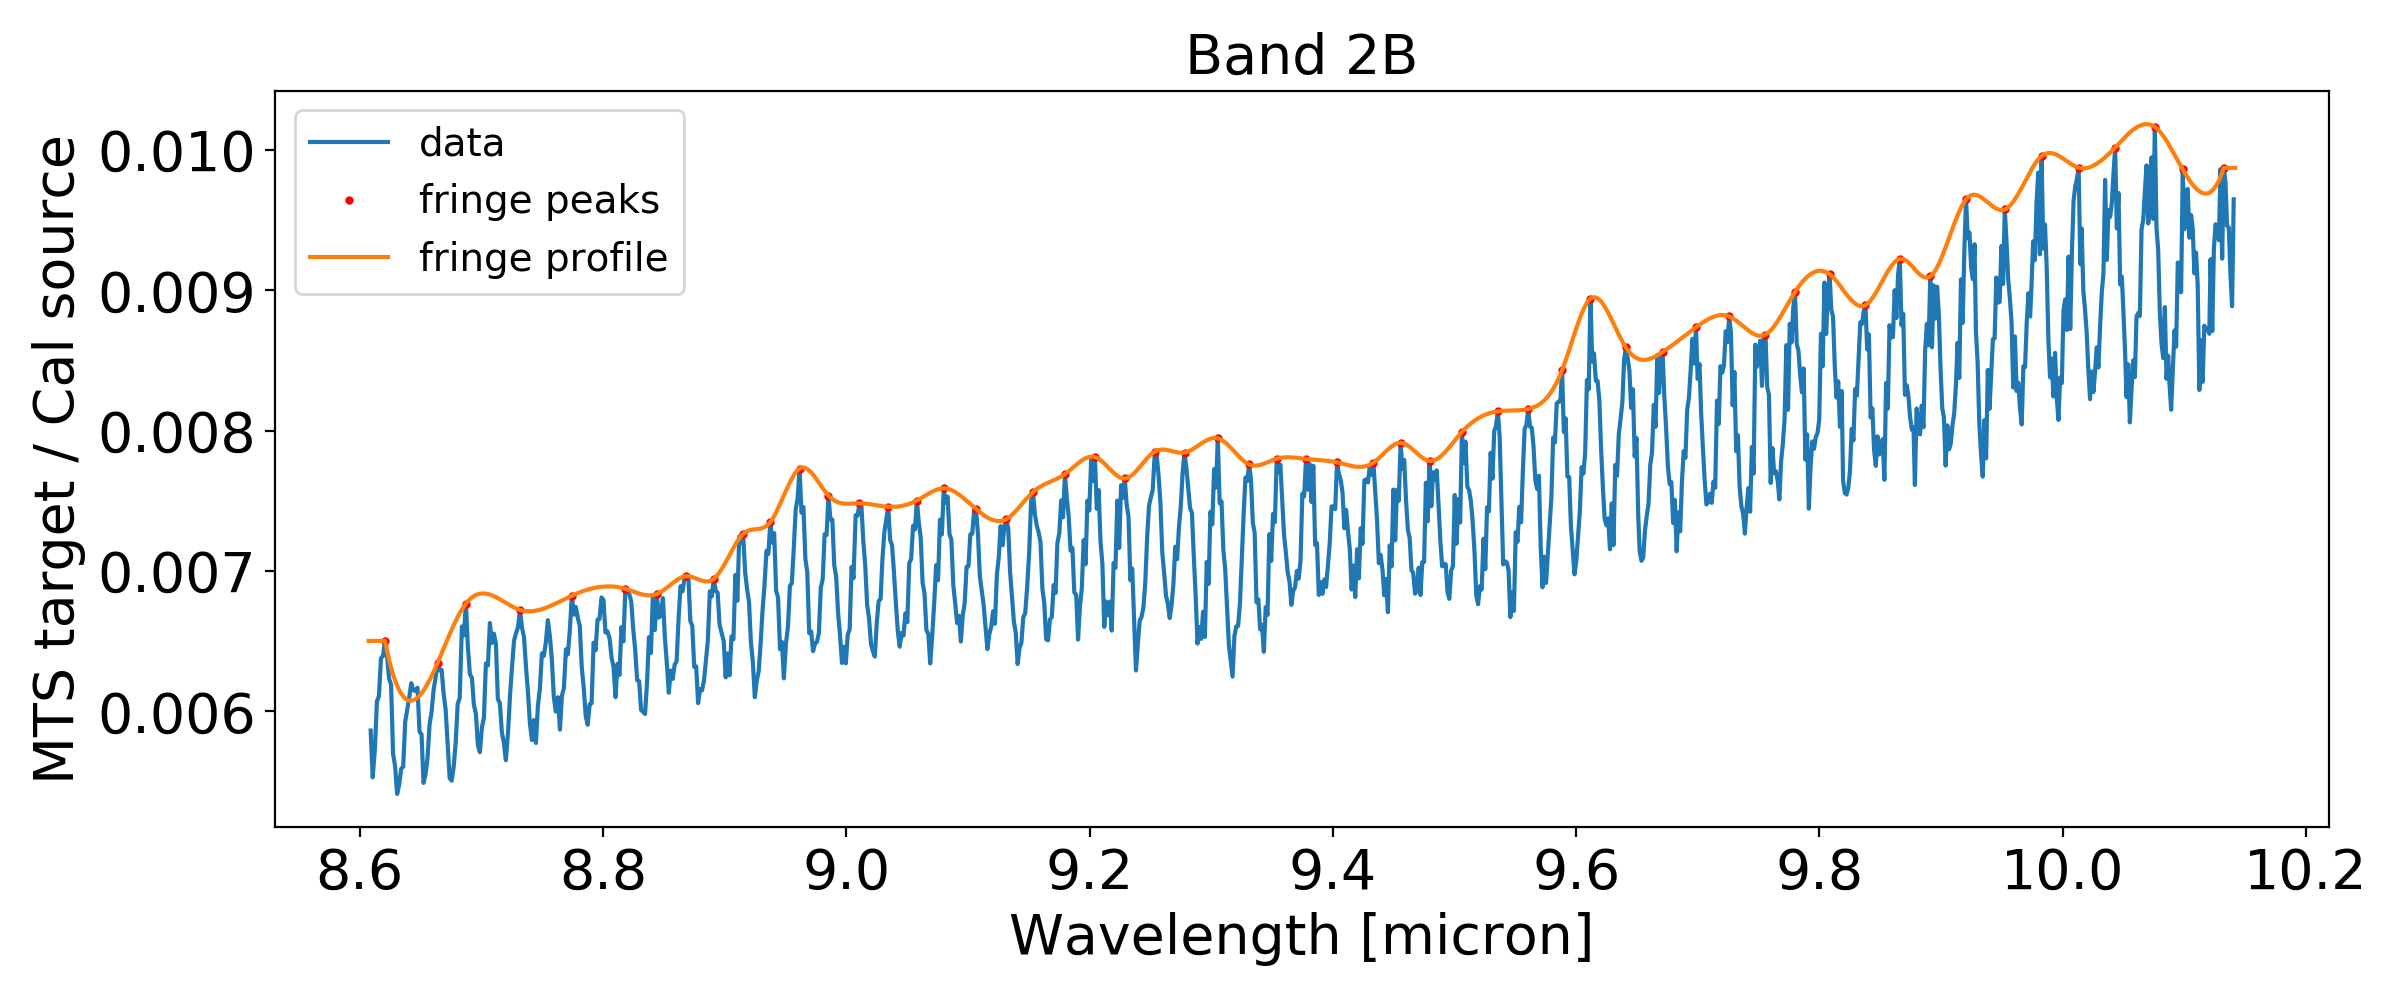

<IPython.core.display.Javascript object>


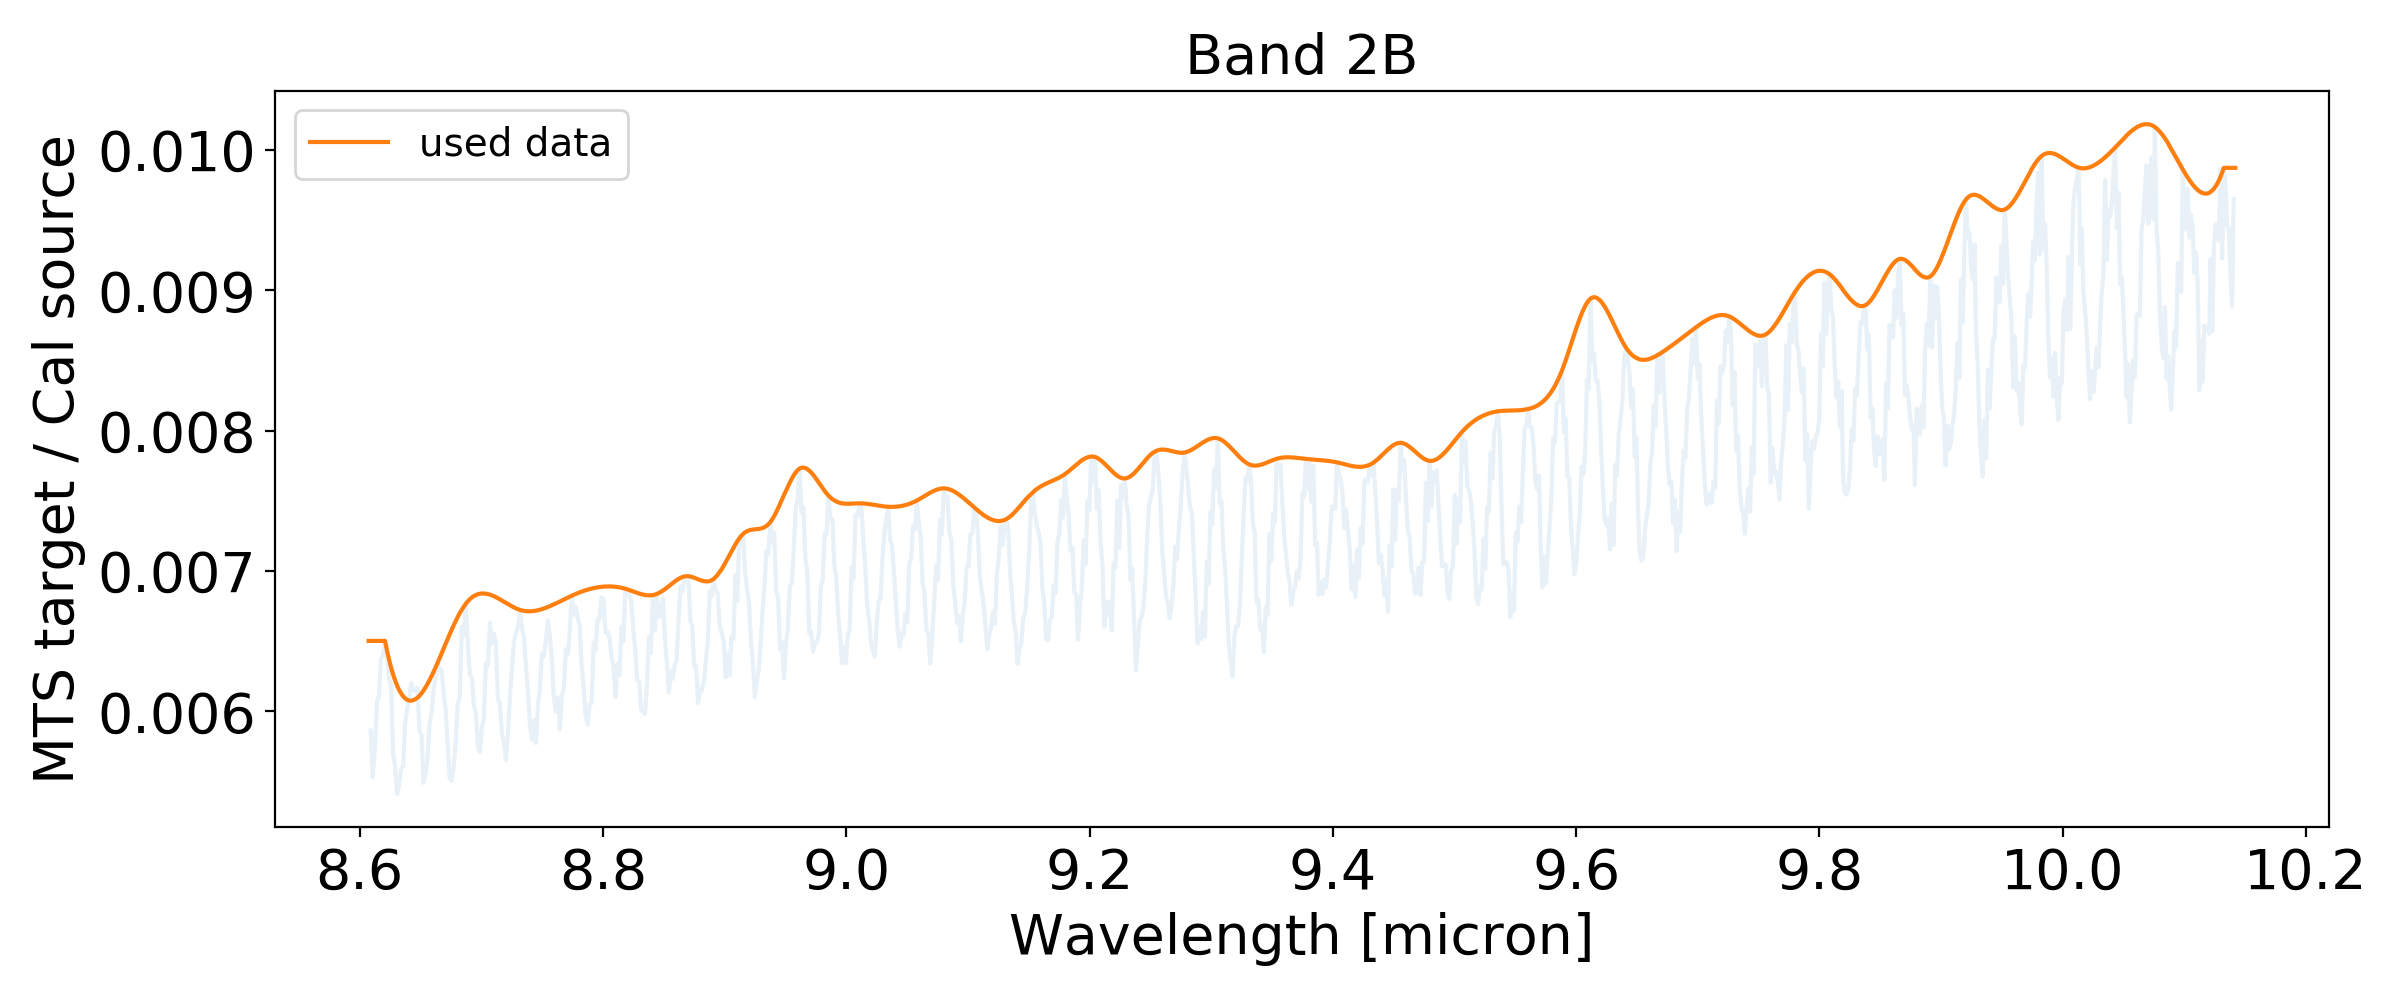

In [108]:
# Examine the OSIM sky flat data in band 1C (wavelength range 5.62-6.73 micron)
band = '2B'
lambdas = lambdaMap[band][ypos,xpos[band]]
data = (ext_source_bkgsubtr[band]/FM_intcal_source_sci[band])[ypos,xpos[band]]
data_noNaN,peaks,data_profile = funcs.norm_fringe(data,thres=0,min_dist=13,k=3,ext=3)

# plot starter analysis
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,label='data')
plt.plot(lambdas[peaks],data_noNaN[peaks],'ro',markersize=2,label='fringe peaks')
plt.plot(lambdas,data_profile,label='fringe profile')
plt.xlabel('Wavelength [micron]')
plt.ylabel('MTS target / Cal source')
plt.legend(loc='upper left')
plt.tight_layout()

# # Investigate regions of interest
# sel = (lambdas >6.62)&(lambdas <6.935)
# popt1     = np.polyfit(lambdas[~sel],data_profile[~sel],3)
# poly1     = np.poly1d(popt1)

# plot resulting fits and residuals
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,alpha=0.1)
plt.plot(lambdas,data_profile,label='used data')
# plt.plot(lambdas,poly1(lambdas),label=r'3rd order polyfit fitted to 6.62$\mu$m>$\lambda$>6.94$\mu$m')
plt.xlabel('Wavelength [micron]')
plt.ylabel('MTS target / Cal source')
plt.legend(loc='upper left')
plt.tight_layout()

<IPython.core.display.Javascript object>


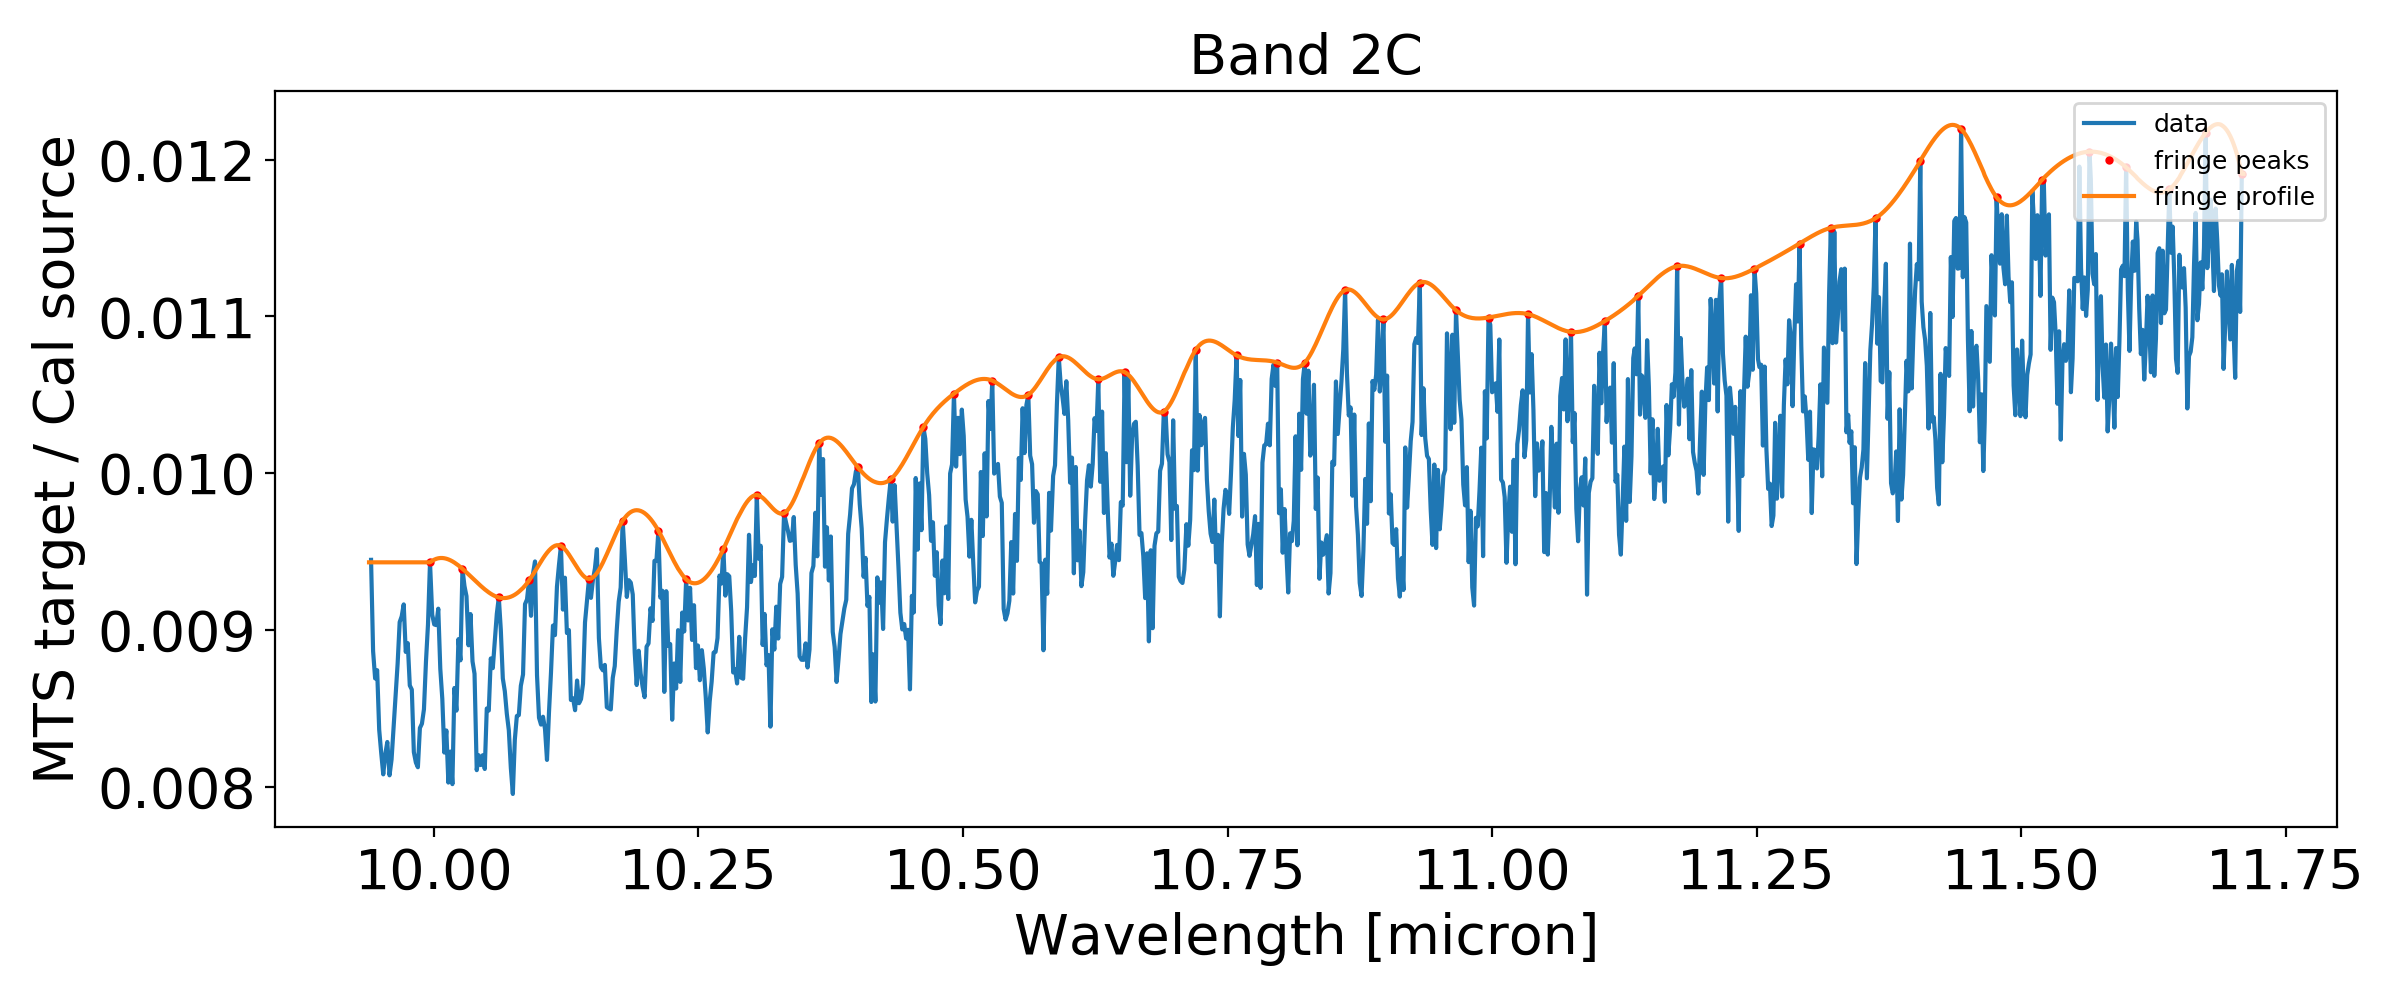

<IPython.core.display.Javascript object>


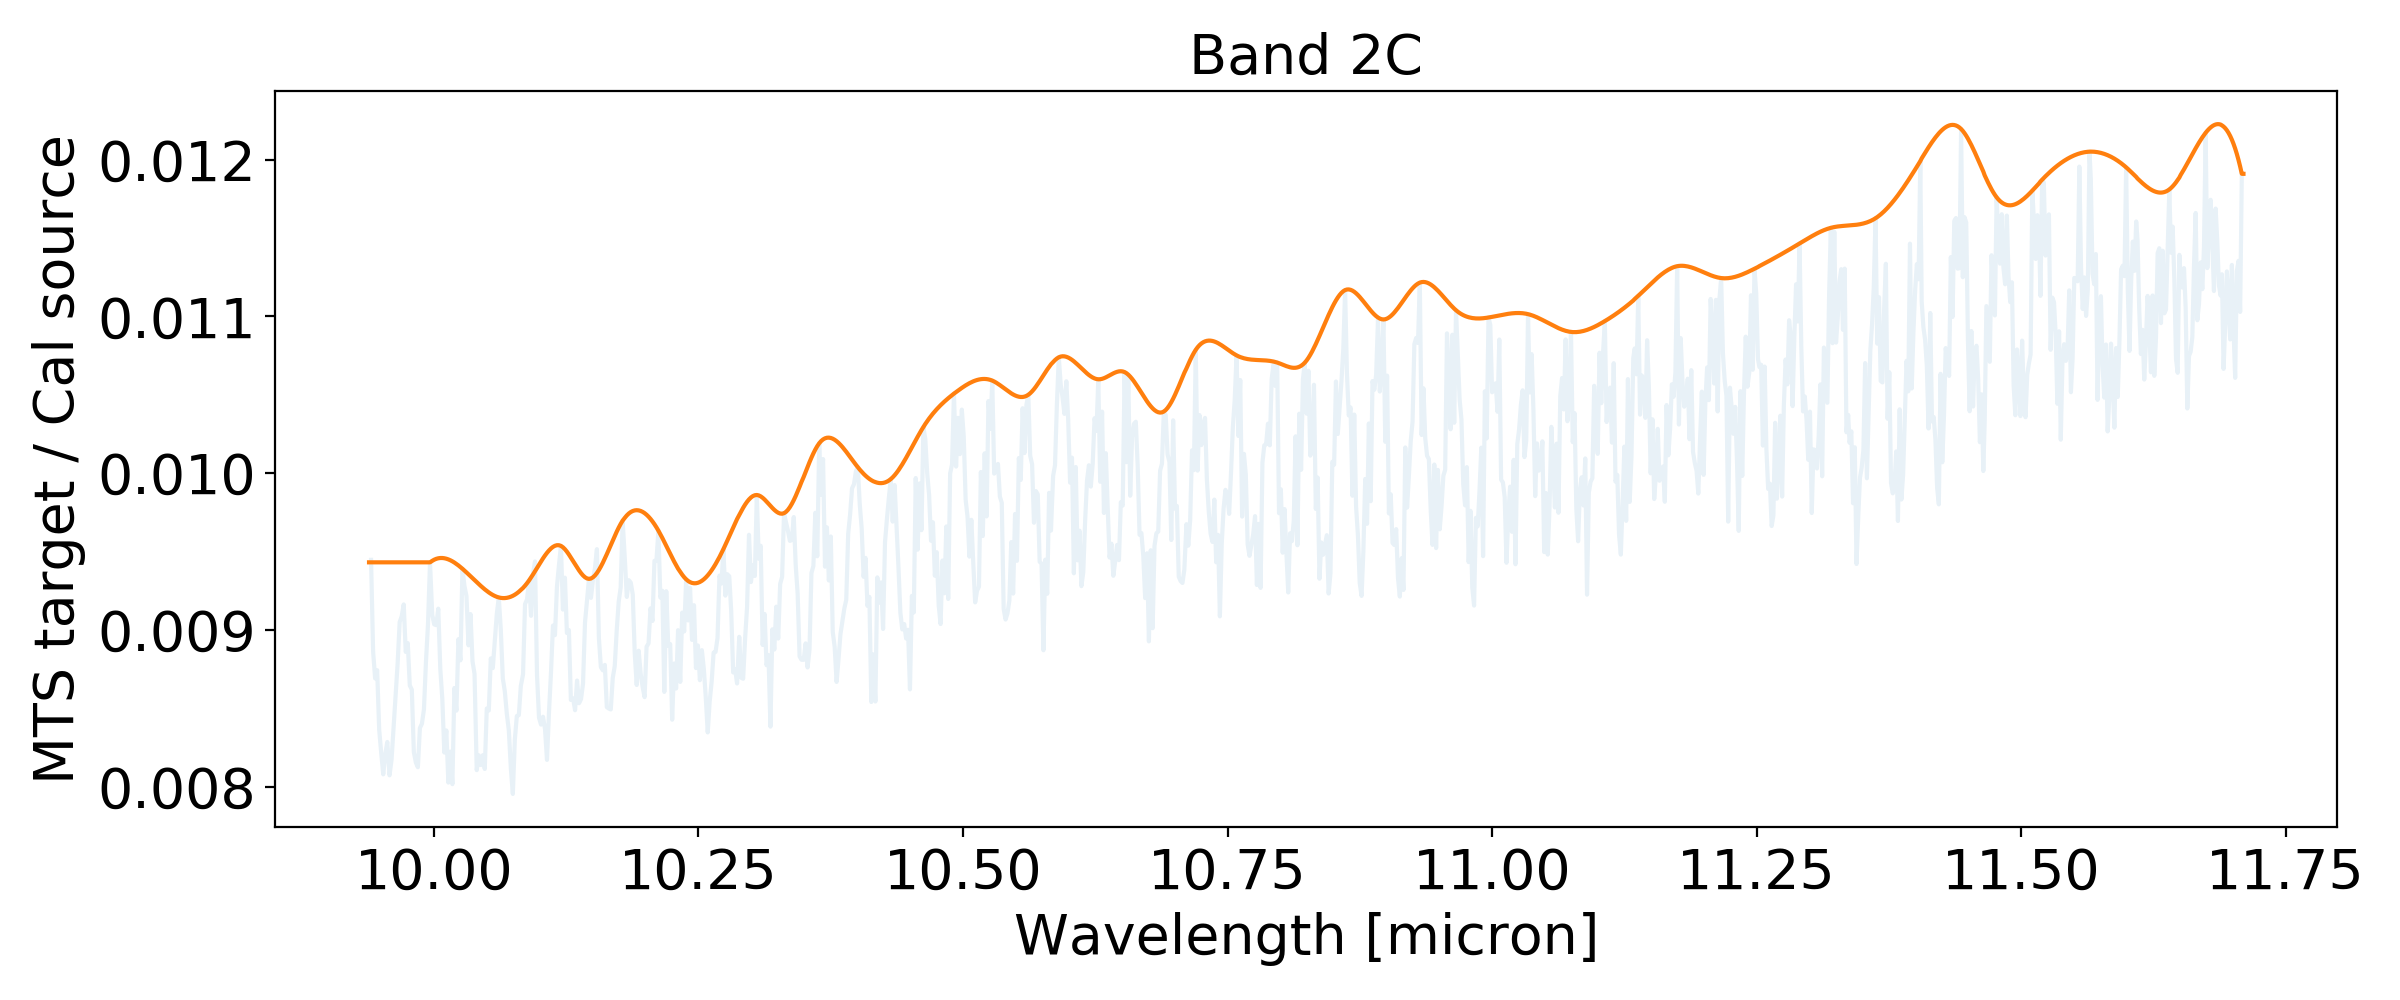

In [109]:
# Examine the OSIM sky flat data in band 1B (wavelength range 5.62-6.73 micron)
band = '2C'
lambdas = lambdaMap[band][ypos,xpos[band]]
data = (ext_source_bkgsubtr[band]/FM_intcal_source_sci[band])[ypos,xpos[band]]
data_noNaN,peaks,data_profile = funcs.norm_fringe(data,thres=0,min_dist=13,k=3,ext=3)
# data_noNaN2,peaks2,data_profile2 = funcs.norm_fringe(data_profile,thres=0,min_dist=20,k=3,ext=3)

# plot starter analysis
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,label='data')
plt.plot(lambdas[peaks],data_noNaN[peaks],'ro',markersize=2,label='fringe peaks')
# plt.plot(lambdas[peaks2],data_noNaN2[peaks2],'ro',markersize=2)
plt.plot(lambdas,data_profile,label='fringe profile')
# plt.plot(lambdas,data_profile2,label='smooth profile')
plt.xlabel('Wavelength [micron]')
plt.ylabel('MTS target / Cal source')
plt.legend(loc='upper right',fontsize=9)
plt.tight_layout()

# plot resulting fits and residuals
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,alpha=0.1)
plt.plot(lambdas,data_profile)
plt.xlabel('Wavelength [micron]')
plt.ylabel('MTS target / Cal source')
plt.legend(loc='upper right')
plt.tight_layout()